In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import re
import copy
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import japanize_matplotlib
import lightgbm as lgb
import math
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
import shap

In [2]:
# この文字列ありますか？関数
def search_object(search,object):
    return bool(re.search(search,object))

In [3]:
# SUUMO物件情報
suumo = pd.read_csv('./data/csv/SuumoDetailsFinal20221108.csv')

# 使用するモデル

In [4]:
# 準備フェイズ

# 事前のデータ加工なし
# 順番をシャッフル
suumo_light = copy.copy(suumo.sample(frac=1,random_state=2))

# 変数は(だいたい使うであろう皆さんを)全部そのまま使用
quantity_features = [
    '皇居からの距離',
#    '歩', # 13
#    'バス', # 16
#    '車', # 2
    '最寄駅からの距離',
#    '部屋数', # 4
    '面積',
    '築年数',
#    '階数', # 5
#    '地下', # 17
    '地上',
    '階',
#    'オプション数', # 0
#    '駐車場距離', # 14
#    '駐車場料金', # 6
#    '条件数', # 9
]
category_features = [
    '市区町村',
    '路線',
    '駅',
    '間取り',
#    '向き', # 1
    '建物種別', # 10
    '構造',
#    '入居', # 15
#    '取引態様',
]
is_features = [
#    '間取り_S', # 11
#    '間取り_L', # 7
#    '間取り_D', # 12
#    '間取り_K', # 3
#    '駐車場有無', # 8
]
target_feature = '家賃'
features = np.r_[quantity_features,category_features,is_features]

# カテゴリ変数をLabelEncoding
LE = LabelEncoder()
for feature in category_features:
    suumo_light[feature] = LE.fit_transform(suumo_light[feature])
    # ラベル対応表も作っておく
    num = np.arange(suumo_light[feature].unique().shape[0])
    name = LE.inverse_transform(num)
    exec(f"table_{feature} = pd.DataFrame(np.c_[num,name],columns=['num','name'])")
    
# カテゴリとisをカテゴリ型に変換
suumo_light[category_features] = suumo_light[category_features].astype('category')
suumo_light[is_features] = suumo_light[is_features].astype('category')

In [5]:
# 賃料に対数変換を施す
suumo_light['家賃'] = np.log10(suumo_light['家賃'])

In [6]:
# Xとyを定義
X = suumo_light[features]
y = suumo_light[target_feature]


# 学習用とテスト用に分割
train_test = 0.7
train_valid = 0.8

X_train_before, X_test, y_train_before, y_test = train_test_split(X, y, train_size = train_test, random_state = 0)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_before, y_train_before, train_size = train_valid, random_state = 0)

In [7]:
# モデルを構築、学習

LGBM = lgb.LGBMRegressor(
    n_estimators = 5000,
#    num_leaves = 1000, 
    random_state = 0,
    importance_type = 'gain'
)

verbose_eval = 1
LGBM.fit(X_train,y_train,
        eval_set=[(X_valid,y_valid)],
        eval_metric = 'mse',
        callbacks = [lgb.early_stopping(stopping_rounds=10,verbose=True),
                    lgb.log_evaluation(verbose_eval)])

Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.


[1]	valid_0's l2: 0.0299088
Training until validation scores don't improve for 10 rounds
[2]	valid_0's l2: 0.0253301
[3]	valid_0's l2: 0.0215658
[4]	valid_0's l2: 0.0184664
[5]	valid_0's l2: 0.0159211
[6]	valid_0's l2: 0.0137106
[7]	valid_0's l2: 0.0118926
[8]	valid_0's l2: 0.0103827
[9]	valid_0's l2: 0.00913653
[10]	valid_0's l2: 0.00812594
[11]	valid_0's l2: 0.00722829
[12]	valid_0's l2: 0.00647552
[13]	valid_0's l2: 0.00584686
[14]	valid_0's l2: 0.00532667
[15]	valid_0's l2: 0.00488295
[16]	valid_0's l2: 0.00450454
[17]	valid_0's l2: 0.00418269
[18]	valid_0's l2: 0.00389712
[19]	valid_0's l2: 0.00365075
[20]	valid_0's l2: 0.00344438
[21]	valid_0's l2: 0.0032662
[22]	valid_0's l2: 0.00310219
[23]	valid_0's l2: 0.00296577
[24]	valid_0's l2: 0.0028528
[25]	valid_0's l2: 0.00274823
[26]	valid_0's l2: 0.0026536
[27]	valid_0's l2: 0.00257275
[28]	valid_0's l2: 0.00250104
[29]	valid_0's l2: 0.00243596
[30]	valid_0's l2: 0.00237538
[31]	valid_0's l2: 0.00232211
[32]	valid_0's l2: 0.00227242

[303]	valid_0's l2: 0.00137841
[304]	valid_0's l2: 0.00137778
[305]	valid_0's l2: 0.00137694
[306]	valid_0's l2: 0.00137649
[307]	valid_0's l2: 0.00137586
[308]	valid_0's l2: 0.00137535
[309]	valid_0's l2: 0.00137471
[310]	valid_0's l2: 0.00137438
[311]	valid_0's l2: 0.00137412
[312]	valid_0's l2: 0.00137368
[313]	valid_0's l2: 0.0013727
[314]	valid_0's l2: 0.0013723
[315]	valid_0's l2: 0.00137193
[316]	valid_0's l2: 0.00137153
[317]	valid_0's l2: 0.00137084
[318]	valid_0's l2: 0.00137028
[319]	valid_0's l2: 0.00137011
[320]	valid_0's l2: 0.00136933
[321]	valid_0's l2: 0.00136849
[322]	valid_0's l2: 0.00136761
[323]	valid_0's l2: 0.00136704
[324]	valid_0's l2: 0.0013665
[325]	valid_0's l2: 0.00136545
[326]	valid_0's l2: 0.00136461
[327]	valid_0's l2: 0.00136273
[328]	valid_0's l2: 0.00136198
[329]	valid_0's l2: 0.00136078
[330]	valid_0's l2: 0.00136051
[331]	valid_0's l2: 0.00136032
[332]	valid_0's l2: 0.00135961
[333]	valid_0's l2: 0.00135896
[334]	valid_0's l2: 0.00135866
[335]	valid

[572]	valid_0's l2: 0.00125294
[573]	valid_0's l2: 0.00125268
[574]	valid_0's l2: 0.00125239
[575]	valid_0's l2: 0.00125163
[576]	valid_0's l2: 0.00125151
[577]	valid_0's l2: 0.00125135
[578]	valid_0's l2: 0.00125101
[579]	valid_0's l2: 0.00125054
[580]	valid_0's l2: 0.00125067
[581]	valid_0's l2: 0.00125033
[582]	valid_0's l2: 0.00124972
[583]	valid_0's l2: 0.00124931
[584]	valid_0's l2: 0.00124908
[585]	valid_0's l2: 0.0012487
[586]	valid_0's l2: 0.0012485
[587]	valid_0's l2: 0.00124811
[588]	valid_0's l2: 0.00124797
[589]	valid_0's l2: 0.00124776
[590]	valid_0's l2: 0.00124759
[591]	valid_0's l2: 0.00124775
[592]	valid_0's l2: 0.00124737
[593]	valid_0's l2: 0.00124722
[594]	valid_0's l2: 0.00124696
[595]	valid_0's l2: 0.00124684
[596]	valid_0's l2: 0.0012468
[597]	valid_0's l2: 0.00124657
[598]	valid_0's l2: 0.00124619
[599]	valid_0's l2: 0.00124581
[600]	valid_0's l2: 0.00124557
[601]	valid_0's l2: 0.00124535
[602]	valid_0's l2: 0.00124502
[603]	valid_0's l2: 0.00124487
[604]	valid

[840]	valid_0's l2: 0.00118469
[841]	valid_0's l2: 0.00118471
[842]	valid_0's l2: 0.00118441
[843]	valid_0's l2: 0.00118397
[844]	valid_0's l2: 0.00118374
[845]	valid_0's l2: 0.00118337
[846]	valid_0's l2: 0.00118324
[847]	valid_0's l2: 0.00118312
[848]	valid_0's l2: 0.00118299
[849]	valid_0's l2: 0.00118279
[850]	valid_0's l2: 0.00118292
[851]	valid_0's l2: 0.00118276
[852]	valid_0's l2: 0.00118257
[853]	valid_0's l2: 0.00118227
[854]	valid_0's l2: 0.00118182
[855]	valid_0's l2: 0.00118169
[856]	valid_0's l2: 0.00118141
[857]	valid_0's l2: 0.00118131
[858]	valid_0's l2: 0.00118114
[859]	valid_0's l2: 0.00118107
[860]	valid_0's l2: 0.00118076
[861]	valid_0's l2: 0.00118056
[862]	valid_0's l2: 0.0011805
[863]	valid_0's l2: 0.00118016
[864]	valid_0's l2: 0.00117989
[865]	valid_0's l2: 0.00117958
[866]	valid_0's l2: 0.0011795
[867]	valid_0's l2: 0.00117959
[868]	valid_0's l2: 0.00117937
[869]	valid_0's l2: 0.00117915
[870]	valid_0's l2: 0.00117885
[871]	valid_0's l2: 0.00117861
[872]	vali

[1128]	valid_0's l2: 0.00112983
[1129]	valid_0's l2: 0.0011297
[1130]	valid_0's l2: 0.00112955
[1131]	valid_0's l2: 0.00112923
[1132]	valid_0's l2: 0.00112904
[1133]	valid_0's l2: 0.00112878
[1134]	valid_0's l2: 0.00112845
[1135]	valid_0's l2: 0.0011282
[1136]	valid_0's l2: 0.00112793
[1137]	valid_0's l2: 0.00112774
[1138]	valid_0's l2: 0.00112768
[1139]	valid_0's l2: 0.0011276
[1140]	valid_0's l2: 0.00112713
[1141]	valid_0's l2: 0.00112693
[1142]	valid_0's l2: 0.00112687
[1143]	valid_0's l2: 0.00112671
[1144]	valid_0's l2: 0.00112651
[1145]	valid_0's l2: 0.00112631
[1146]	valid_0's l2: 0.00112611
[1147]	valid_0's l2: 0.00112573
[1148]	valid_0's l2: 0.00112553
[1149]	valid_0's l2: 0.00112538
[1150]	valid_0's l2: 0.00112527
[1151]	valid_0's l2: 0.0011251
[1152]	valid_0's l2: 0.001125
[1153]	valid_0's l2: 0.00112484
[1154]	valid_0's l2: 0.0011245
[1155]	valid_0's l2: 0.00112442
[1156]	valid_0's l2: 0.00112421
[1157]	valid_0's l2: 0.00112417
[1158]	valid_0's l2: 0.00112405
[1159]	valid_0'

[1393]	valid_0's l2: 0.00109615
[1394]	valid_0's l2: 0.00109601
[1395]	valid_0's l2: 0.00109572
[1396]	valid_0's l2: 0.00109603
[1397]	valid_0's l2: 0.00109595
[1398]	valid_0's l2: 0.00109582
[1399]	valid_0's l2: 0.00109567
[1400]	valid_0's l2: 0.00109563
[1401]	valid_0's l2: 0.00109557
[1402]	valid_0's l2: 0.00109551
[1403]	valid_0's l2: 0.00109543
[1404]	valid_0's l2: 0.00109529
[1405]	valid_0's l2: 0.00109522
[1406]	valid_0's l2: 0.00109509
[1407]	valid_0's l2: 0.00109491
[1408]	valid_0's l2: 0.00109479
[1409]	valid_0's l2: 0.00109461
[1410]	valid_0's l2: 0.00109446
[1411]	valid_0's l2: 0.0010943
[1412]	valid_0's l2: 0.00109415
[1413]	valid_0's l2: 0.00109405
[1414]	valid_0's l2: 0.00109379
[1415]	valid_0's l2: 0.00109371
[1416]	valid_0's l2: 0.00109361
[1417]	valid_0's l2: 0.00109348
[1418]	valid_0's l2: 0.00109358
[1419]	valid_0's l2: 0.00109339
[1420]	valid_0's l2: 0.00109321
[1421]	valid_0's l2: 0.0010931
[1422]	valid_0's l2: 0.001093
[1423]	valid_0's l2: 0.00109293
[1424]	valid

[1655]	valid_0's l2: 0.00106297
[1656]	valid_0's l2: 0.00106274
[1657]	valid_0's l2: 0.00106255
[1658]	valid_0's l2: 0.00106244
[1659]	valid_0's l2: 0.00106227
[1660]	valid_0's l2: 0.00106224
[1661]	valid_0's l2: 0.00106209
[1662]	valid_0's l2: 0.00106201
[1663]	valid_0's l2: 0.00106196
[1664]	valid_0's l2: 0.00106173
[1665]	valid_0's l2: 0.00106172
[1666]	valid_0's l2: 0.0010616
[1667]	valid_0's l2: 0.00106146
[1668]	valid_0's l2: 0.00106125
[1669]	valid_0's l2: 0.00106118
[1670]	valid_0's l2: 0.0010611
[1671]	valid_0's l2: 0.00106098
[1672]	valid_0's l2: 0.00106084
[1673]	valid_0's l2: 0.00106059
[1674]	valid_0's l2: 0.0010605
[1675]	valid_0's l2: 0.00106046
[1676]	valid_0's l2: 0.00106031
[1677]	valid_0's l2: 0.00106024
[1678]	valid_0's l2: 0.0010602
[1679]	valid_0's l2: 0.00106011
[1680]	valid_0's l2: 0.00106003
[1681]	valid_0's l2: 0.00105995
[1682]	valid_0's l2: 0.00105985
[1683]	valid_0's l2: 0.00105968
[1684]	valid_0's l2: 0.00105952
[1685]	valid_0's l2: 0.00105936
[1686]	valid

[1916]	valid_0's l2: 0.00103498
[1917]	valid_0's l2: 0.00103482
[1918]	valid_0's l2: 0.00103508
[1919]	valid_0's l2: 0.00103497
[1920]	valid_0's l2: 0.00103481
[1921]	valid_0's l2: 0.00103476
[1922]	valid_0's l2: 0.00103463
[1923]	valid_0's l2: 0.00103454
[1924]	valid_0's l2: 0.00103435
[1925]	valid_0's l2: 0.00103417
[1926]	valid_0's l2: 0.00103395
[1927]	valid_0's l2: 0.00103396
[1928]	valid_0's l2: 0.00103387
[1929]	valid_0's l2: 0.00103386
[1930]	valid_0's l2: 0.00103374
[1931]	valid_0's l2: 0.00103368
[1932]	valid_0's l2: 0.00103355
[1933]	valid_0's l2: 0.00103342
[1934]	valid_0's l2: 0.0010332
[1935]	valid_0's l2: 0.00103307
[1936]	valid_0's l2: 0.00103295
[1937]	valid_0's l2: 0.00103288
[1938]	valid_0's l2: 0.00103281
[1939]	valid_0's l2: 0.00103269
[1940]	valid_0's l2: 0.00103266
[1941]	valid_0's l2: 0.00103253
[1942]	valid_0's l2: 0.00103246
[1943]	valid_0's l2: 0.00103245
[1944]	valid_0's l2: 0.0010324
[1945]	valid_0's l2: 0.00103241
[1946]	valid_0's l2: 0.00103221
[1947]	val

[2209]	valid_0's l2: 0.0010066
[2210]	valid_0's l2: 0.00100656
[2211]	valid_0's l2: 0.00100674
[2212]	valid_0's l2: 0.0010067
[2213]	valid_0's l2: 0.00100666
[2214]	valid_0's l2: 0.00100654
[2215]	valid_0's l2: 0.00100642
[2216]	valid_0's l2: 0.00100656
[2217]	valid_0's l2: 0.00100647
[2218]	valid_0's l2: 0.00100637
[2219]	valid_0's l2: 0.00100624
[2220]	valid_0's l2: 0.00100612
[2221]	valid_0's l2: 0.00100598
[2222]	valid_0's l2: 0.00100582
[2223]	valid_0's l2: 0.00100592
[2224]	valid_0's l2: 0.00100591
[2225]	valid_0's l2: 0.00100609
[2226]	valid_0's l2: 0.00100637
[2227]	valid_0's l2: 0.00100655
[2228]	valid_0's l2: 0.0010064
[2229]	valid_0's l2: 0.00100624
[2230]	valid_0's l2: 0.00100614
[2231]	valid_0's l2: 0.001006
[2232]	valid_0's l2: 0.00100595
Early stopping, best iteration is:
[2222]	valid_0's l2: 0.00100582


LGBMRegressor(importance_type='gain', n_estimators=5000, random_state=0)

<AxesSubplot:title={'center':'Metric during training'}, xlabel='Iterations', ylabel='l2'>

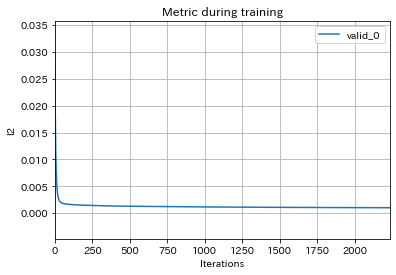

In [8]:
lgb.plot_metric(LGBM)

In [9]:
# それぞれの予測結果を収納
y_train_pred = LGBM.predict(X_train)
y_valid_pred = LGBM.predict(X_valid)
y_test_pred = LGBM.predict(X_test)

In [10]:
# それぞれのr2スコアを算出
print('train:',r2_score(10**y_train,10**y_train_pred))
print('valid:',r2_score(10**y_valid,10**y_valid_pred))
print('test:',r2_score(10**y_test,10**y_test_pred))

train: 0.9887107295151344
valid: 0.9695107151350383
test: 0.961437180987307


In [11]:
# それぞれのMSEを算出
print('train:',mean_squared_error(10**y_train,10**y_train_pred))
print('valid:',mean_squared_error(10**y_valid,10**y_valid_pred))
print('test:',mean_squared_error(10**y_test,10**y_test_pred))

train: 0.6837918212386788
valid: 1.9607326384677803
test: 2.588772545079065


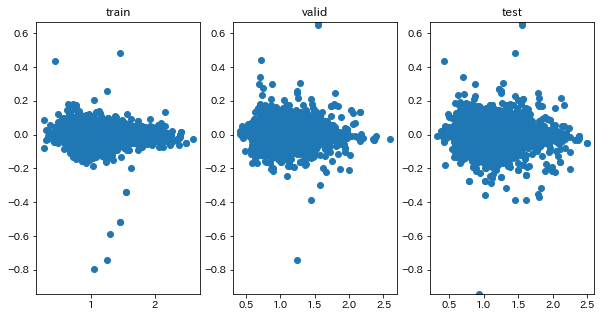

In [12]:
# それぞれの残差プロット
fig = plt.figure(figsize=(10,5))

error_train = y_train_pred - y_train
error_valid = y_valid_pred - y_valid
error_test = y_test_pred - y_test

max_ = error_test.max()
min_ = error_test.min()

ax1 = fig.add_subplot(1,3,1)
ax2 = fig.add_subplot(1,3,2)
ax3 = fig.add_subplot(1,3,3)

ax1.scatter(y_train_pred, error_train)
ax1.title.set_text('train')
ax1.set_ylim(min_,max_)
ax2.scatter(y_valid_pred, error_valid)
ax2.title.set_text('valid')
ax2.set_ylim(min_,max_)
ax3.scatter(y_test_pred, error_test)
ax3.title.set_text('test')
ax3.set_ylim(min_,max_)

plt.show()

In [24]:
# 変数重要度
table_importances = pd.DataFrame(np.c_[features, LGBM.feature_importances_],columns=['feature','importance'])
table_importances['importance'] = table_importances['importance'].astype(float)
table_importances = table_importances.sort_values('importance')
table_importances

feature   importance
10      建物種別    19.519489
1   最寄駅からの距離    96.552352
7         路線   105.027131
5          階   119.719957
0    皇居からの距離   214.233940
11        構造   261.750099
4         地上   276.206803
3        築年数  1246.238831
8          駅  1465.169053
6       市区町村  2069.713720
9        間取り  6234.882283
2         面積  7914.469957

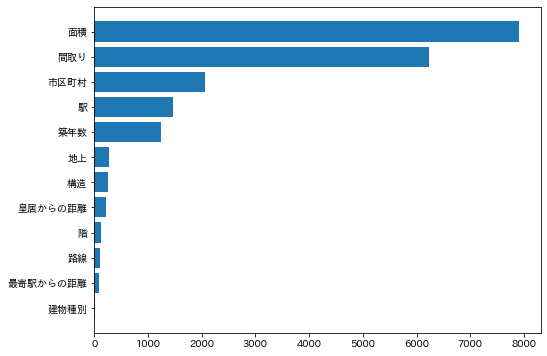

In [25]:
# 変数重要度
plt.figure(figsize=(8,6))
plt.barh(table_importances['feature'],table_importances['importance'])
plt.savefig("./data/image/elite_feature_importances.png")
plt.show()

# SHAPを起動する

In [15]:
# SHAP 準備フェイズ
# 5分は待たされるぞ（10分はかかってない？）
explainer = shap.TreeExplainer(model=LGBM)
shap_values = explainer.shap_values(X=X_test)
shap.initjs()

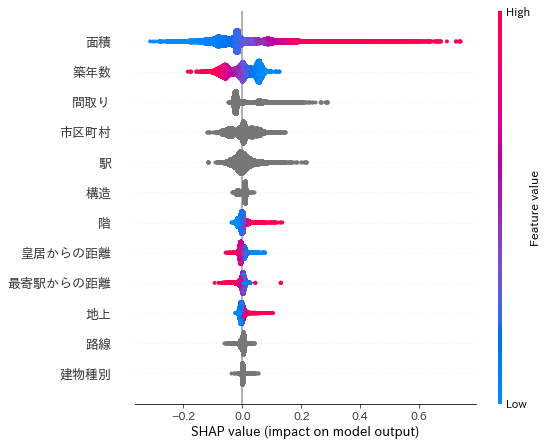

In [16]:
# 各変数の値と影響力
shap.summary_plot(
    shap_values=shap_values,
    features=X_test,
    feature_names=X_test.columns,
    show=False
)
plt.savefig('./data/image/shap_value.png')
plt.show()

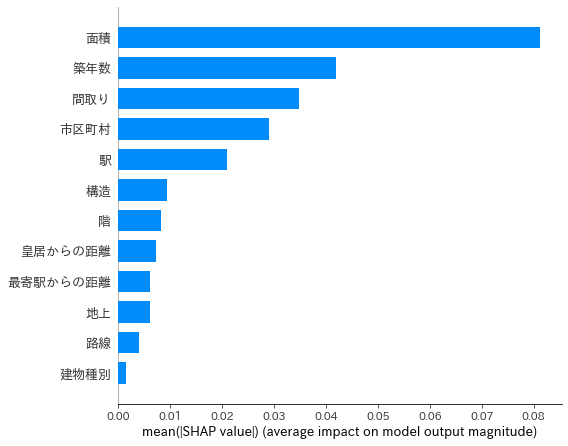

In [17]:
shap.summary_plot(
    shap_values=shap_values,
    features=X_test,
    feature_names=X_test.columns,
    plot_type="bar",
    show=False
)
plt.savefig("./data/image/shap_feature_importance.png")
plt.show()

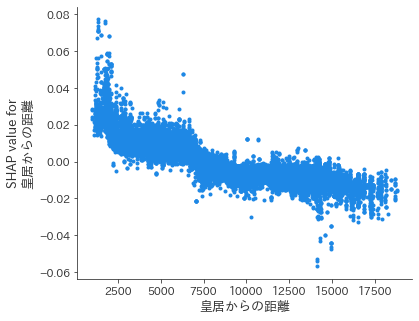

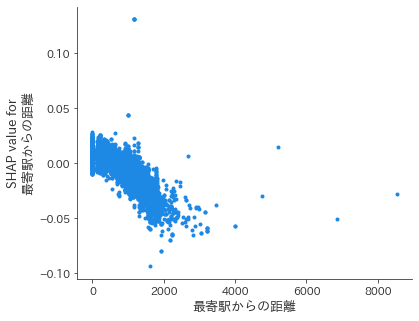

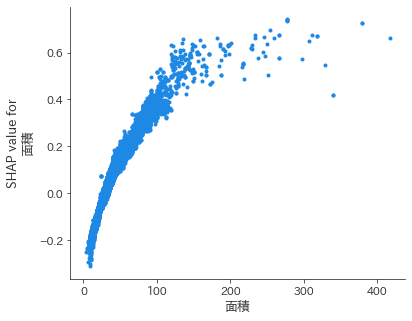

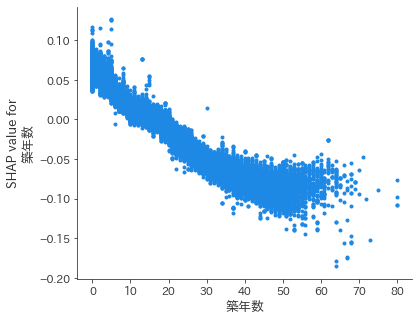

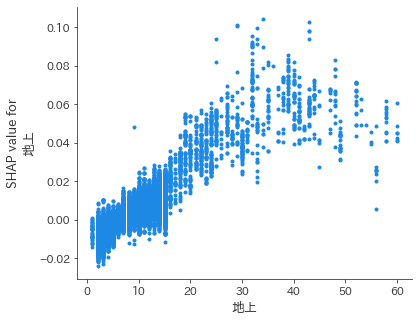

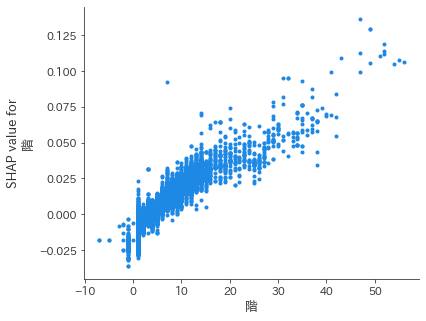

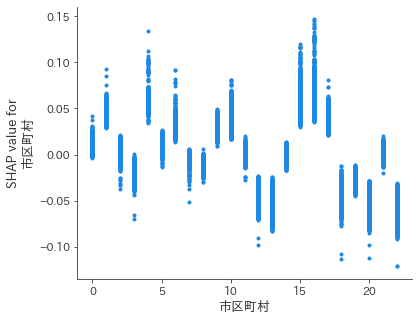

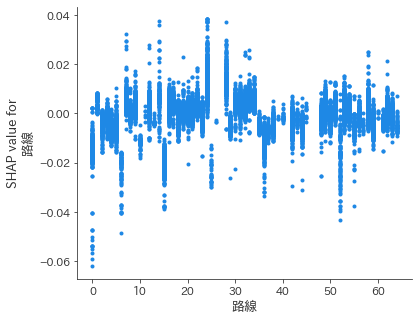

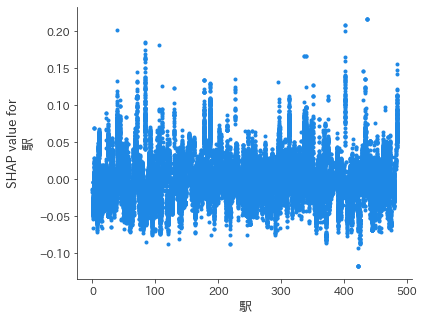

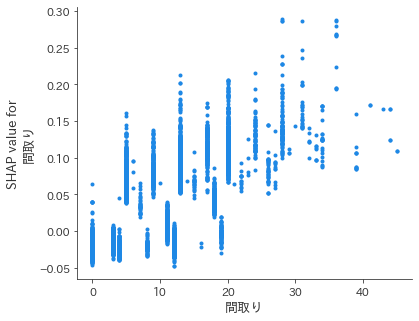

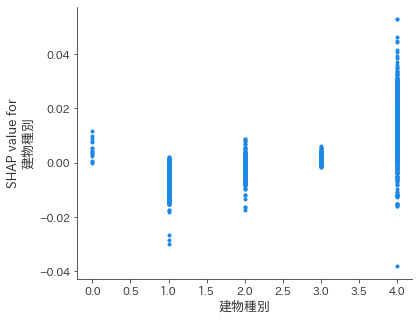

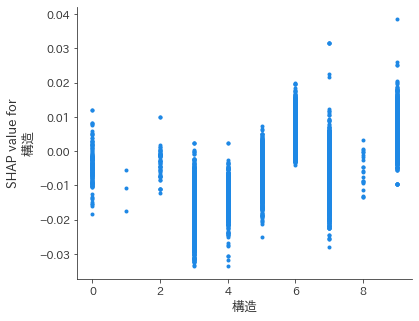

In [18]:
for feature in X_test.columns:

    shap.dependence_plot(
        ind=feature,
        interaction_index=None,
        shap_values=shap_values,
        features=X_test,
        feature_names=X_test.columns,
        show=False
    )
#     plt.savefig(f'./data/image/shap/one_feature/shapvalue_{feature}.png')
    plt.show()

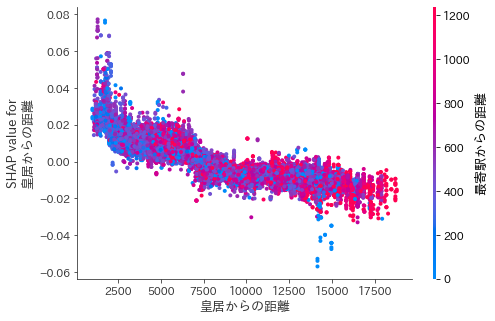

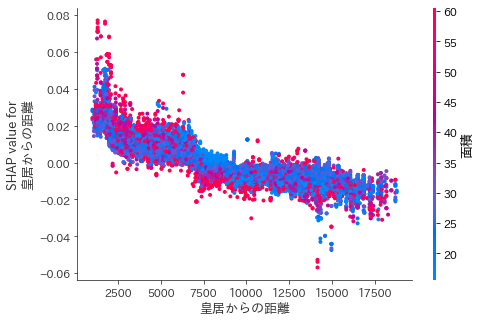

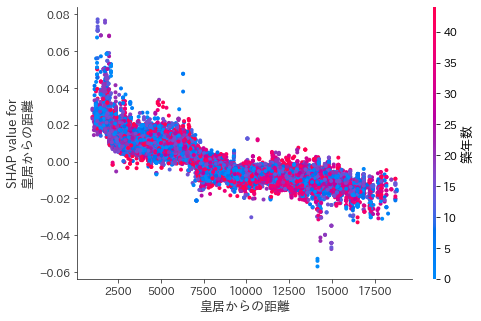

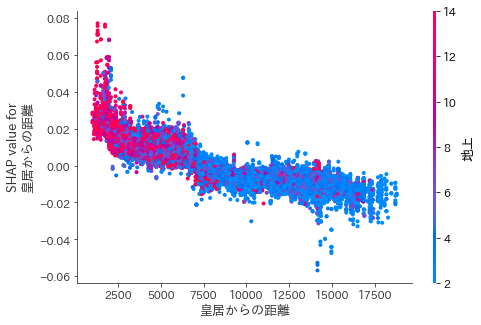

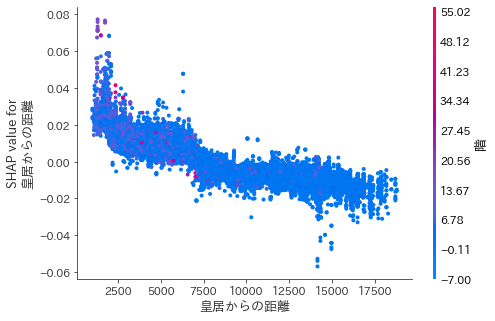

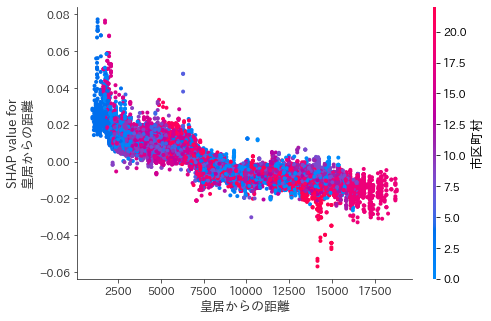

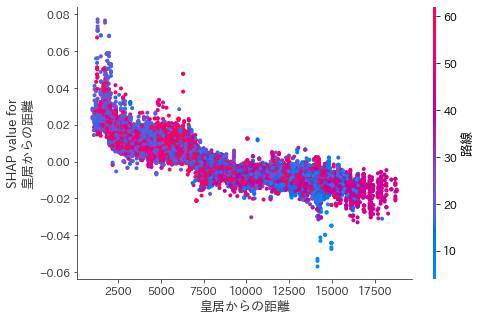

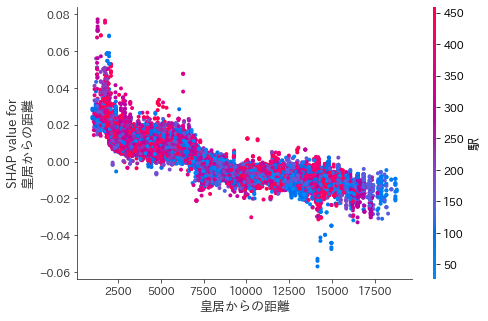

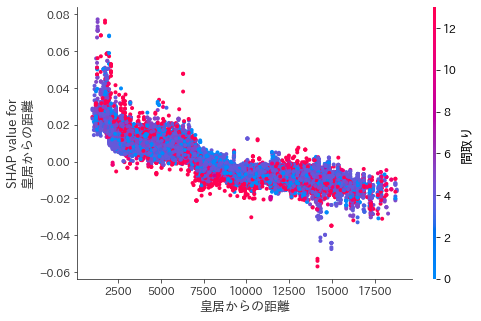

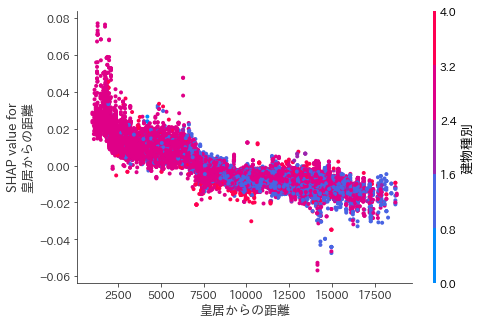

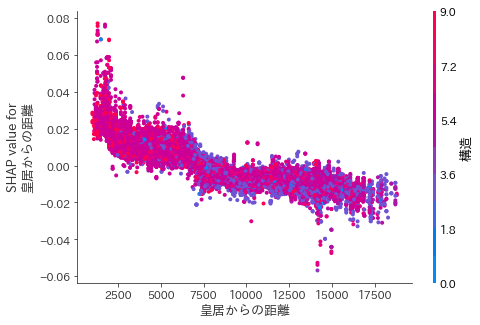

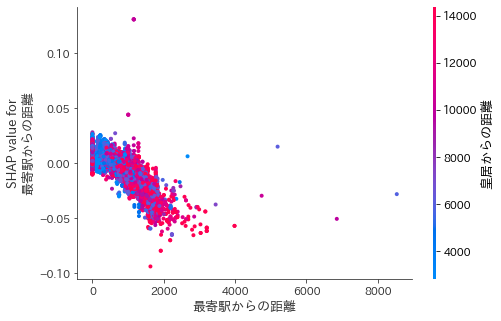

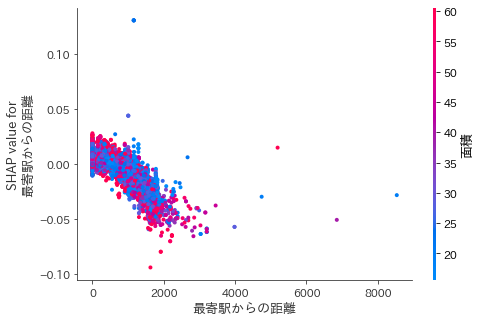

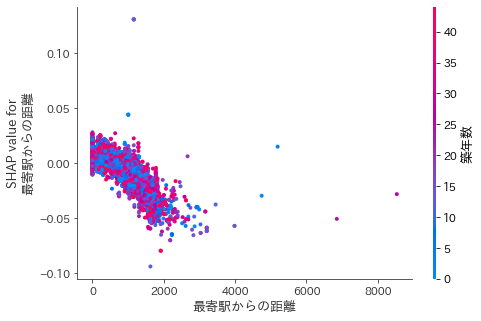

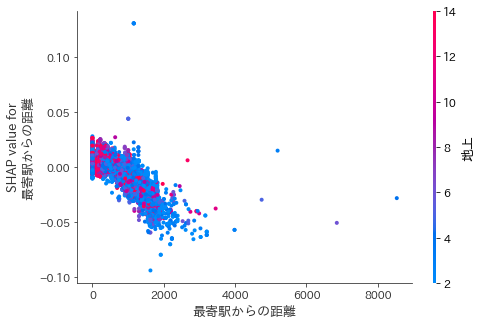

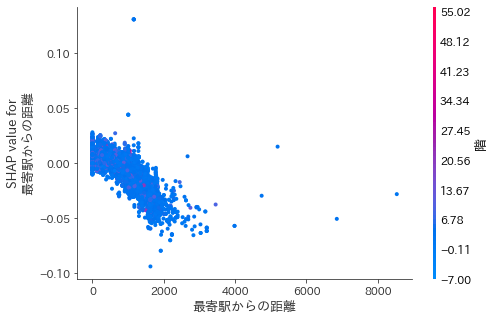

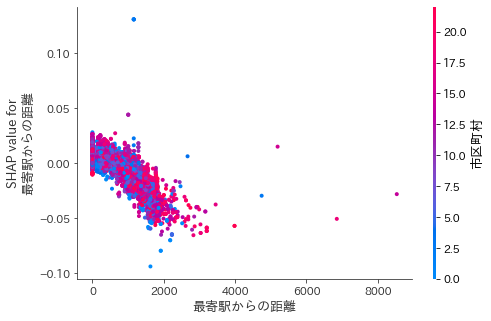

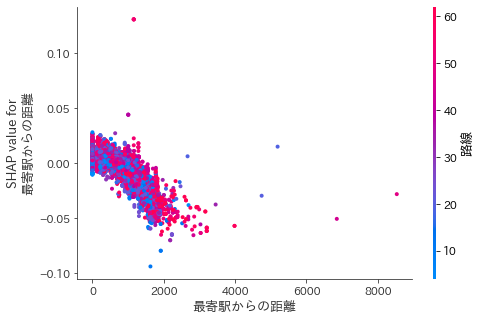

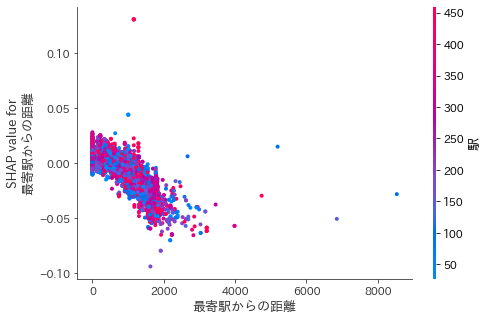

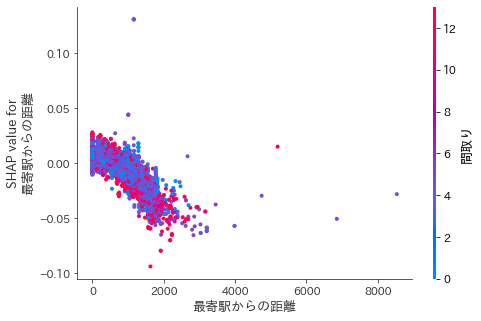

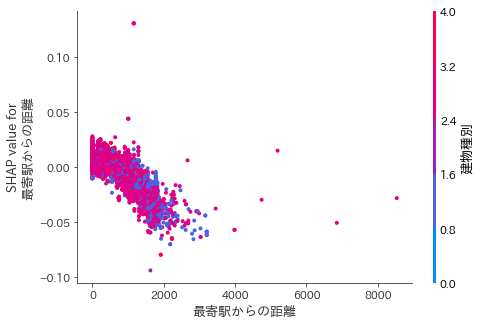

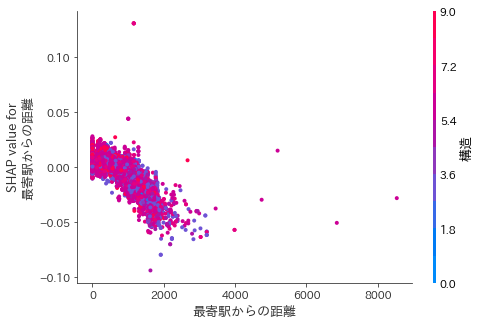

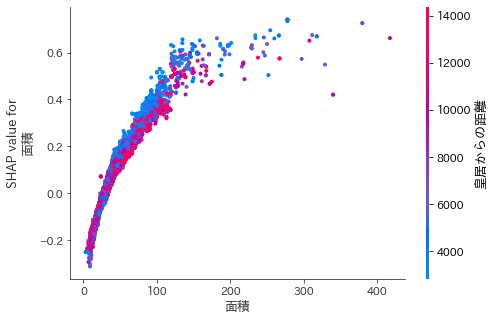

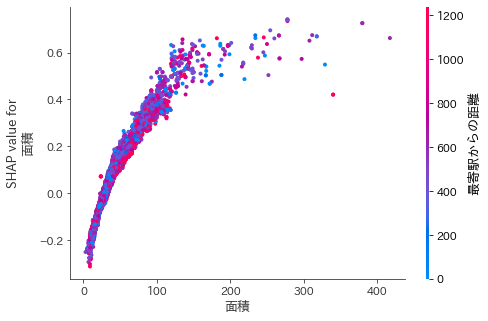

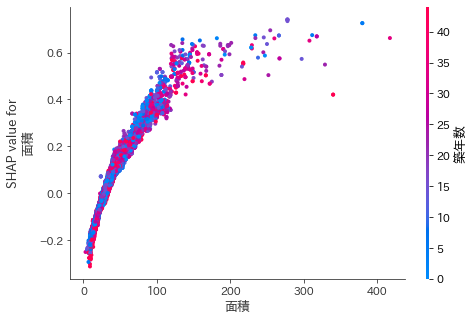

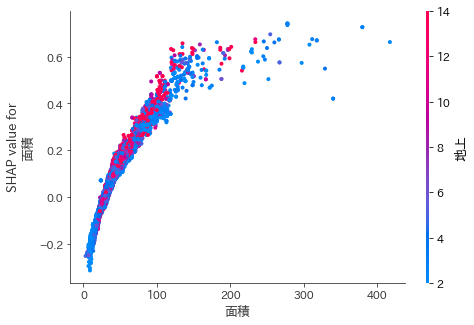

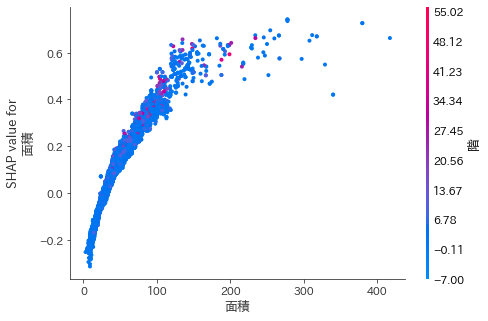

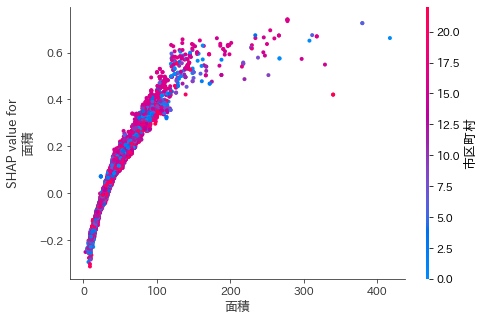

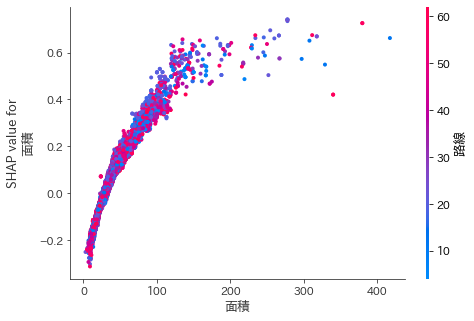

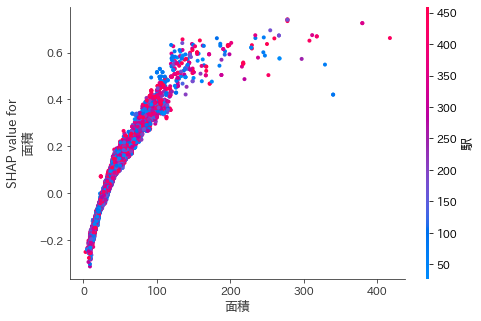

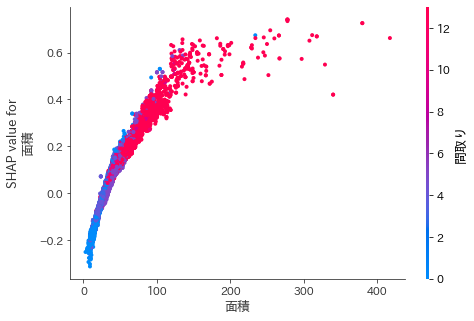

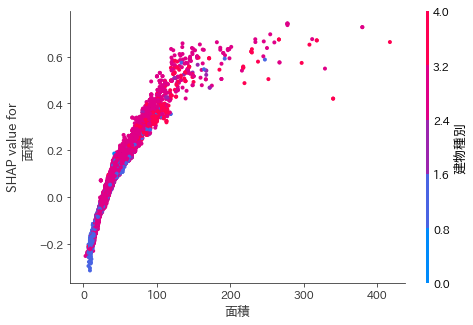

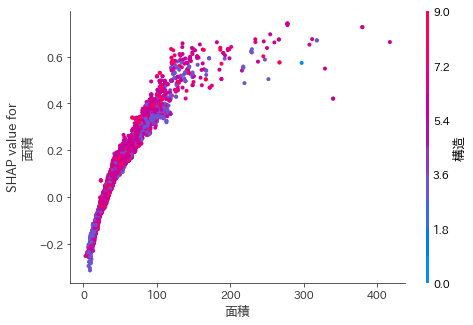

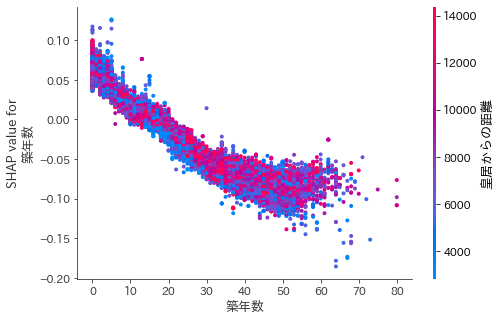

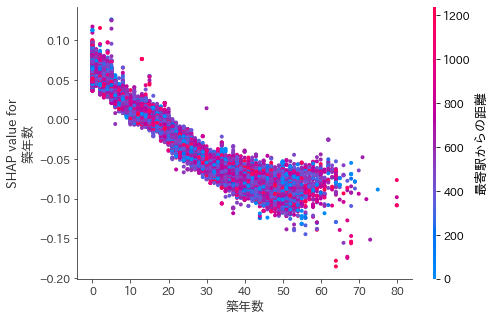

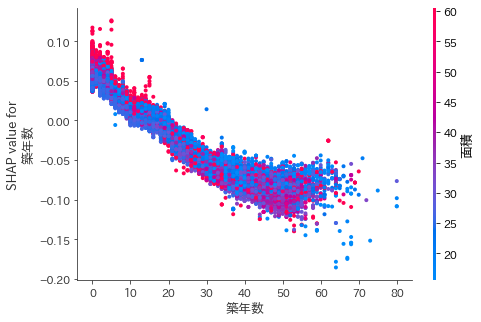

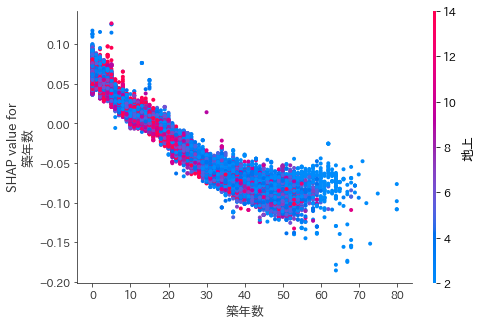

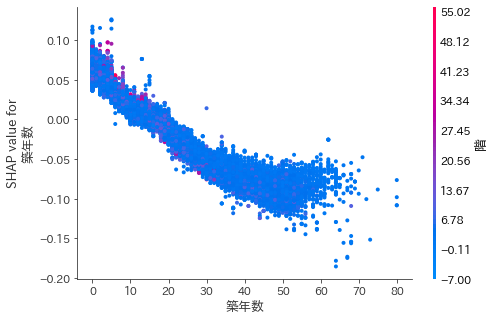

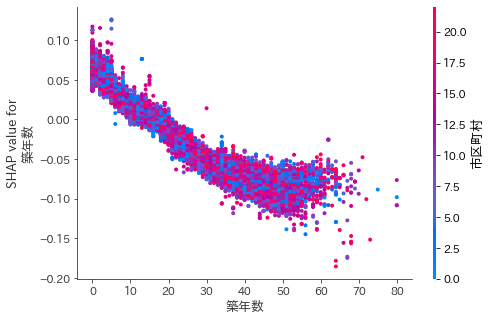

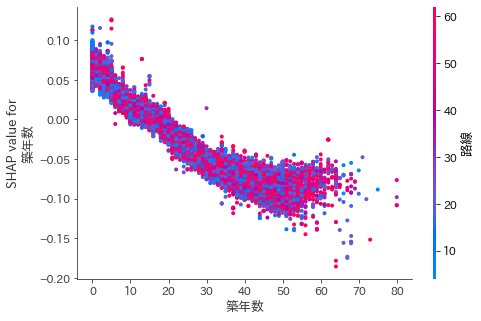

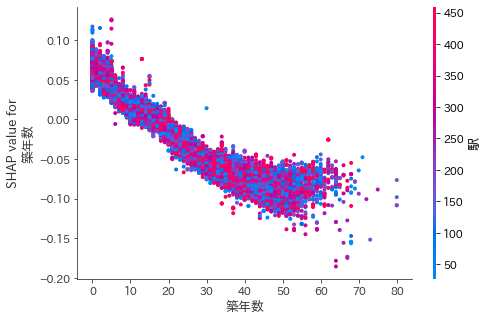

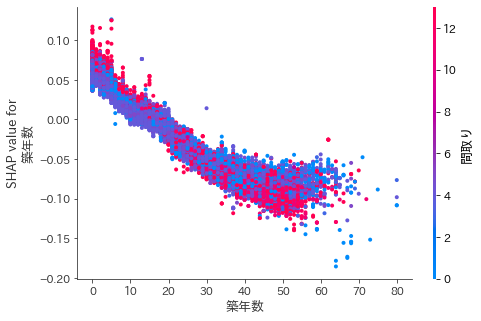

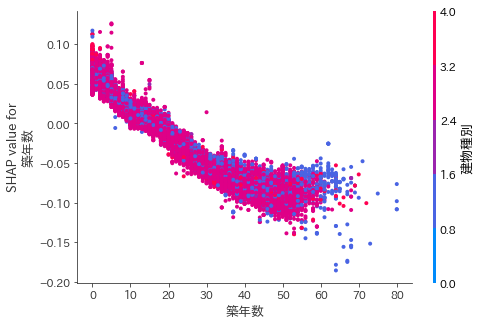

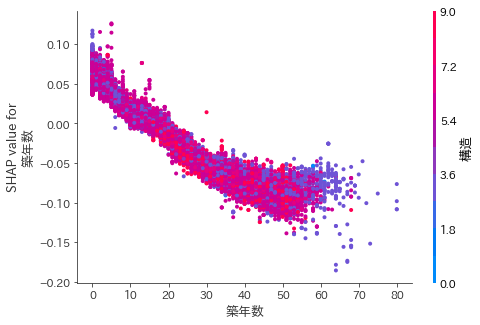

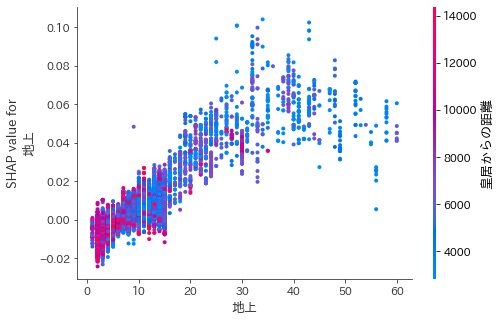

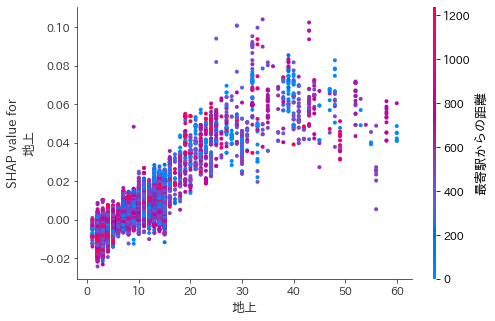

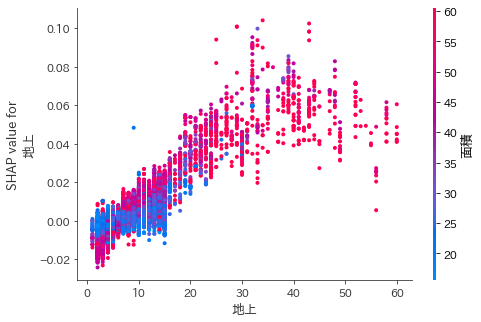

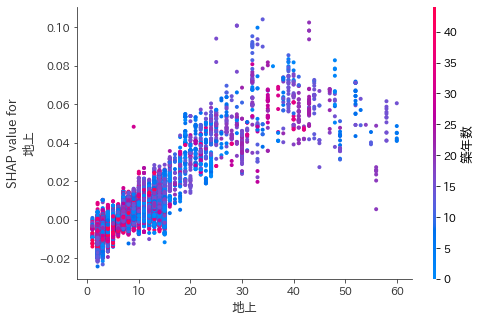

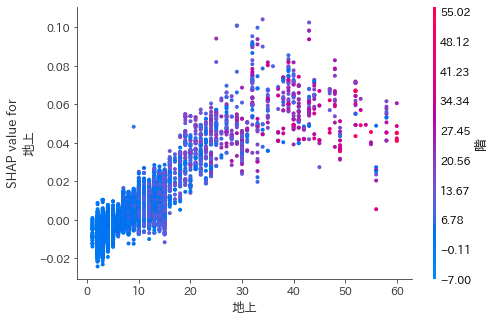

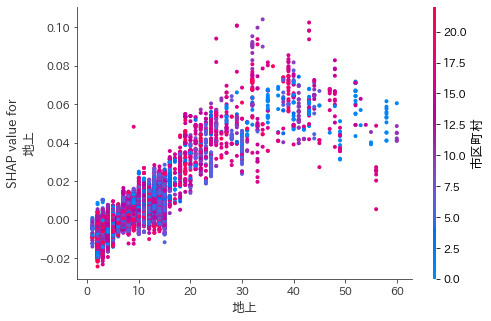

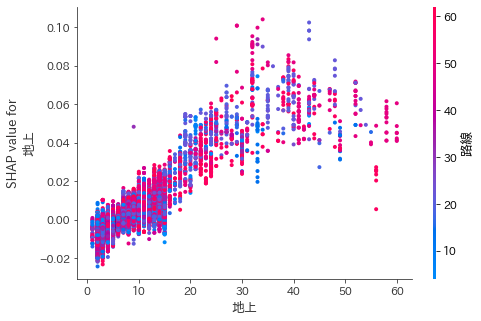

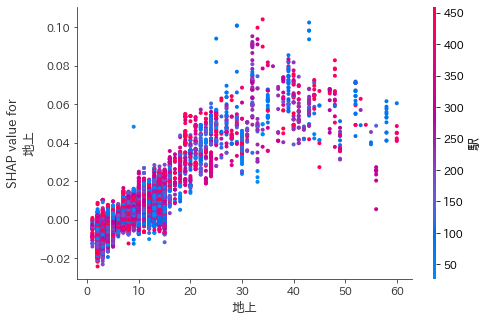

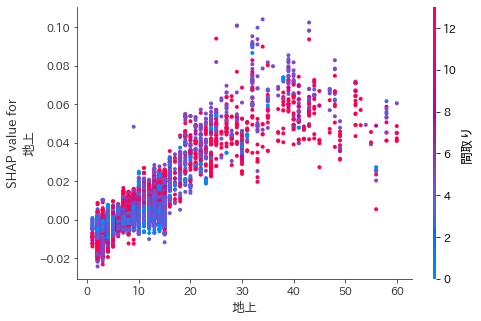

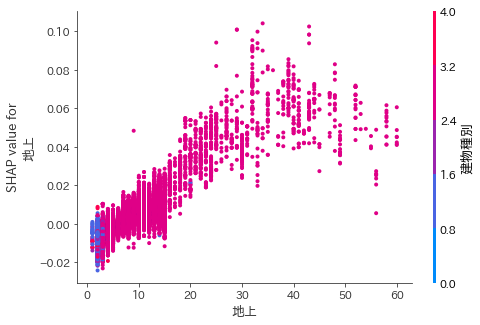

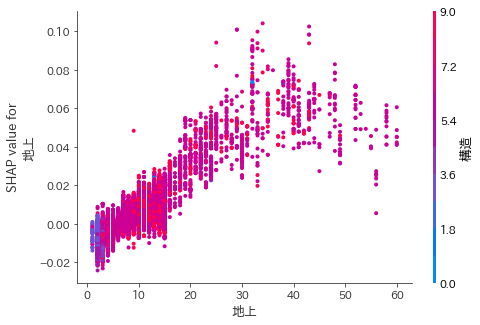

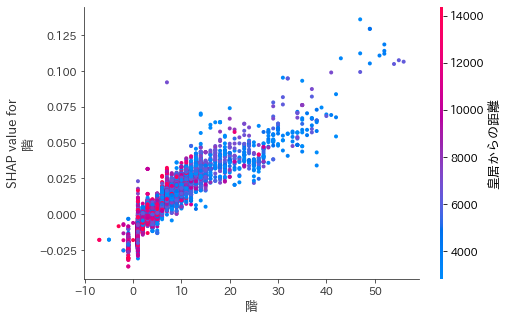

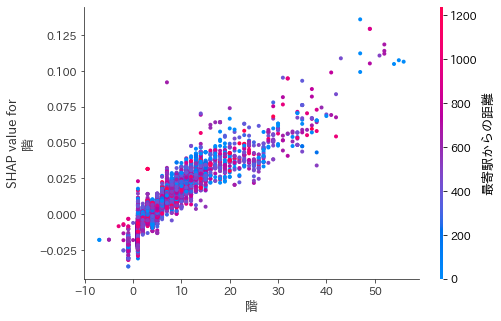

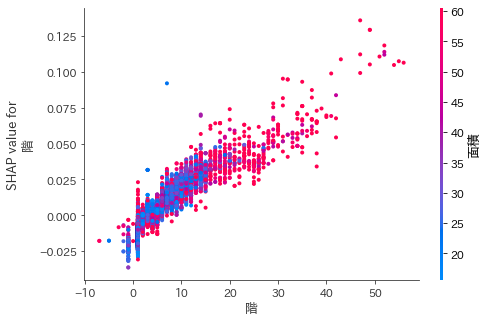

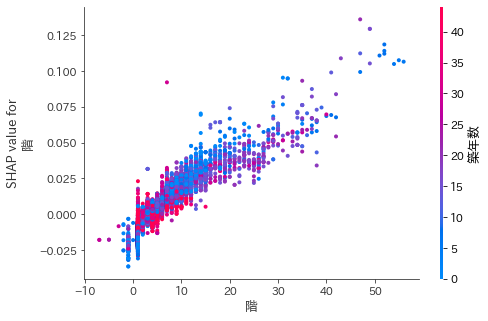

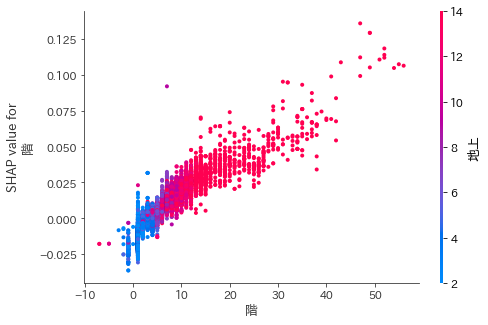

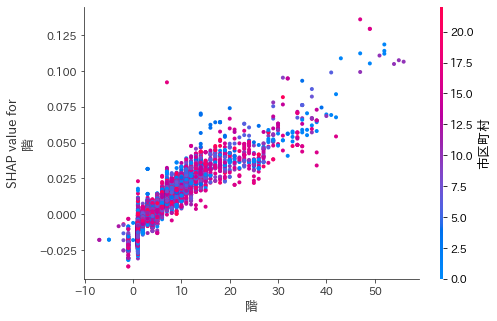

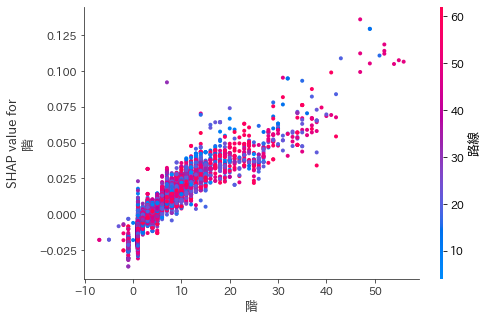

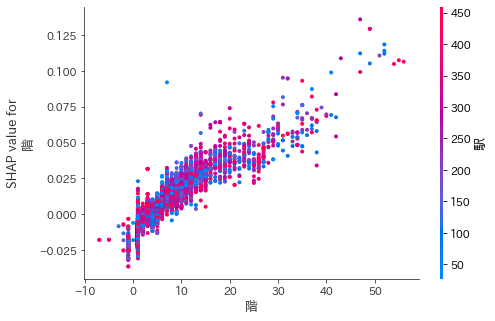

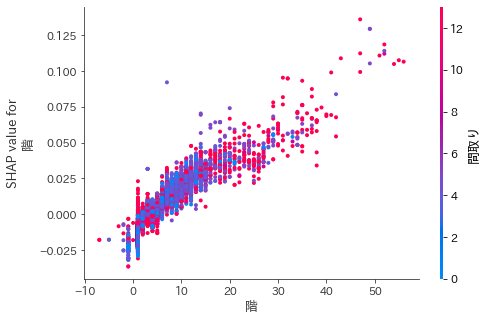

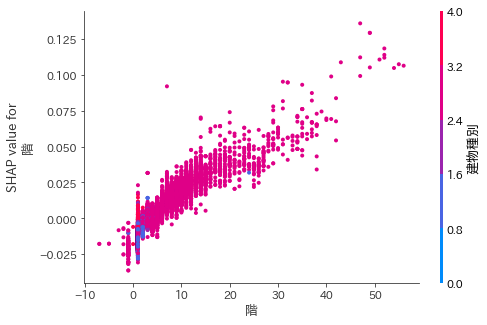

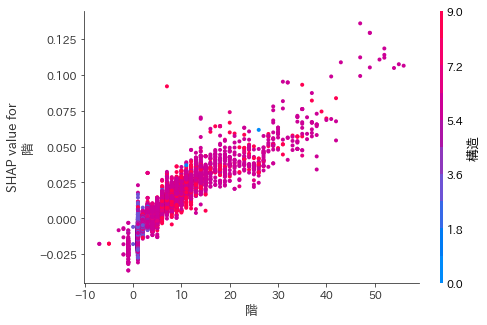

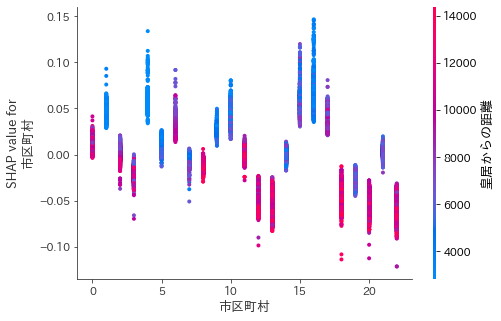

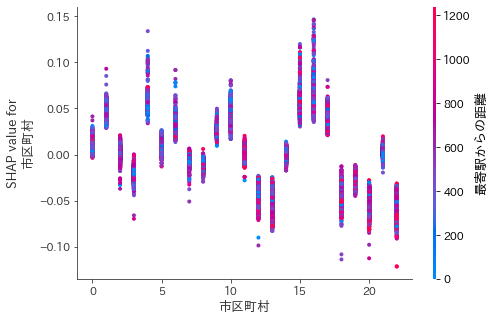

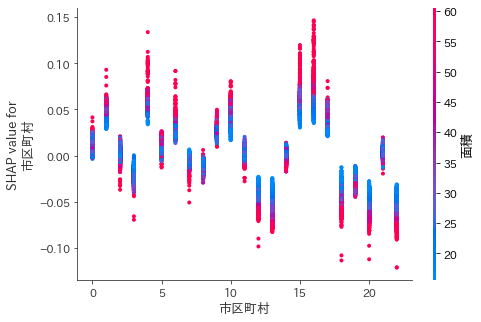

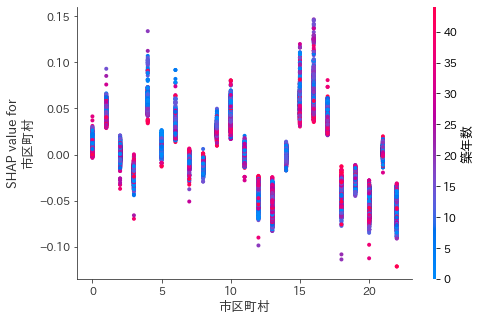

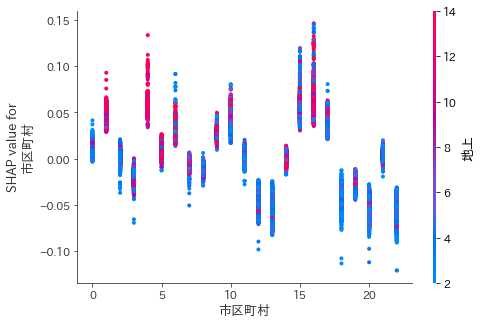

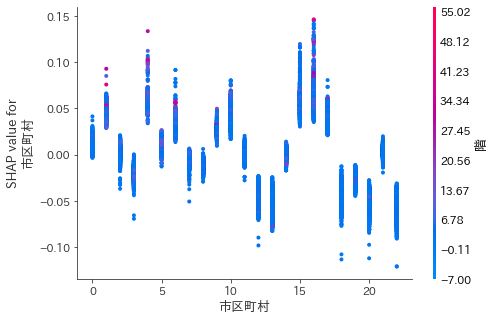

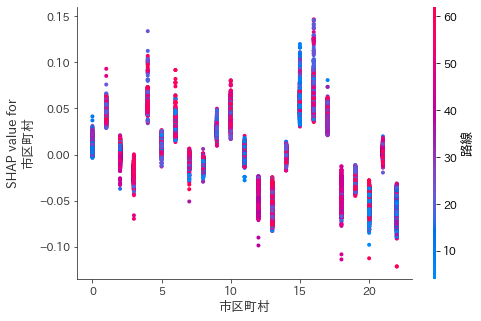

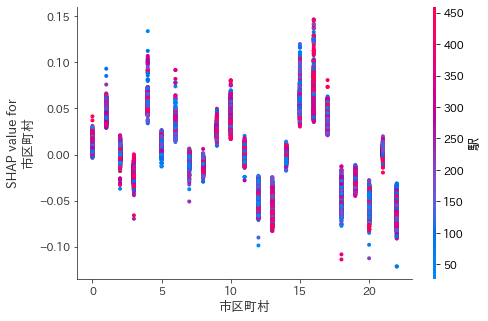

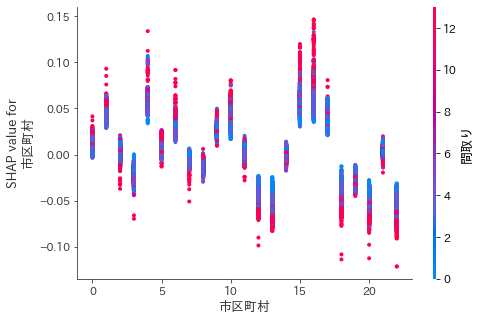

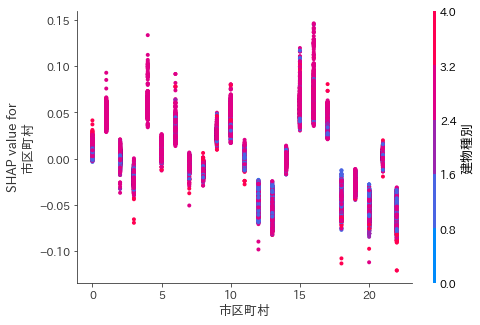

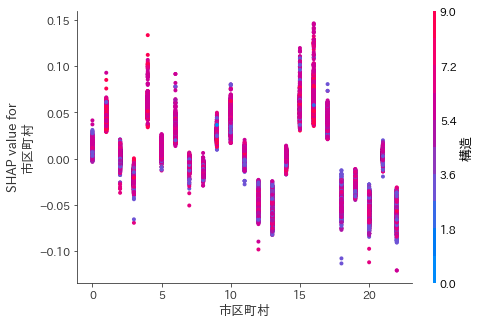

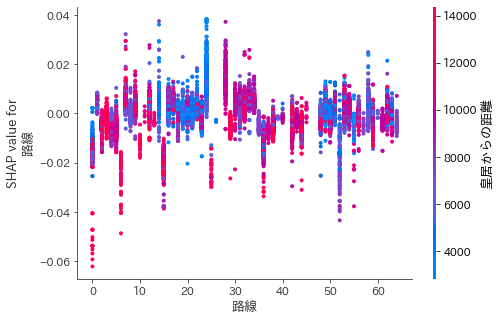

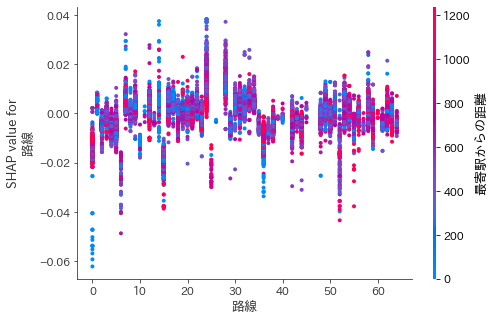

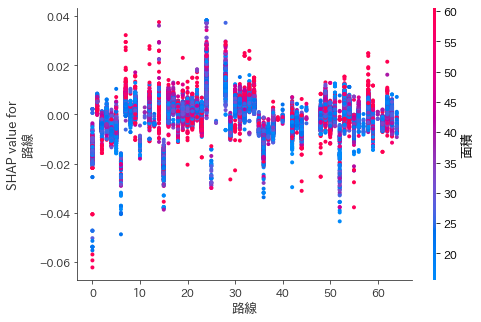

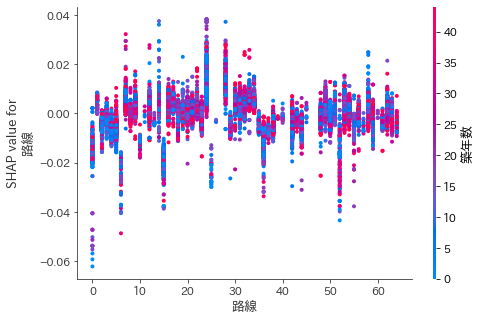

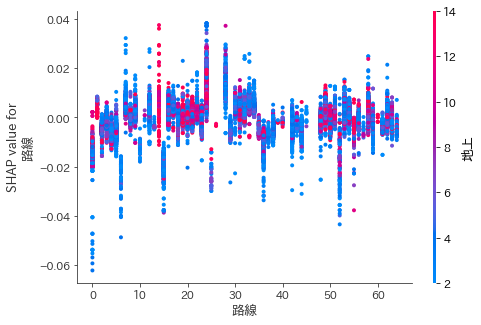

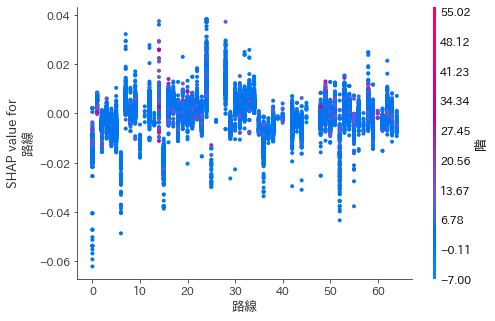

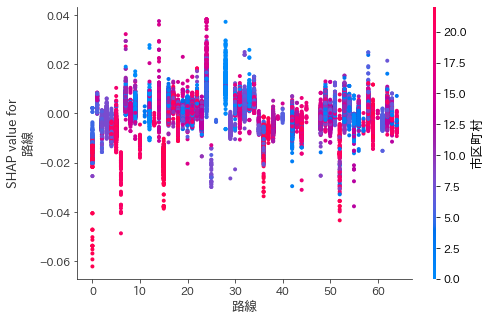

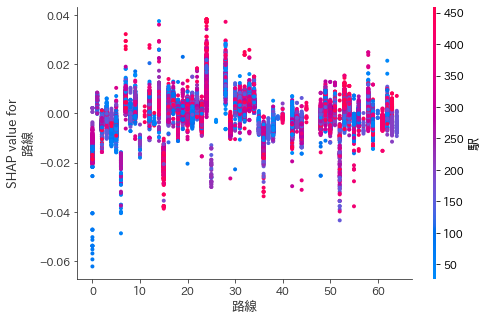

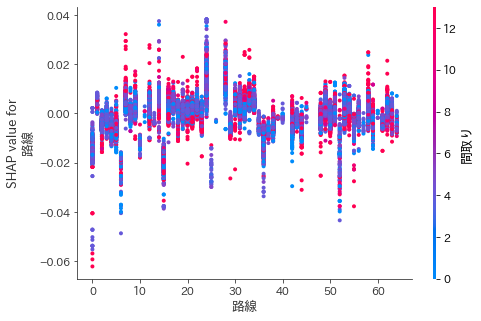

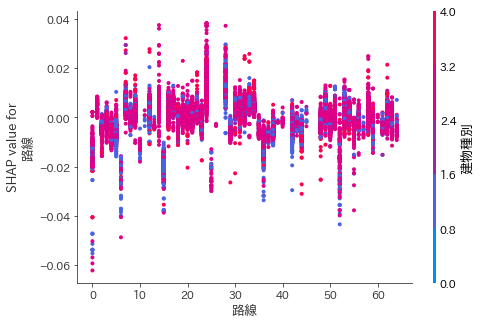

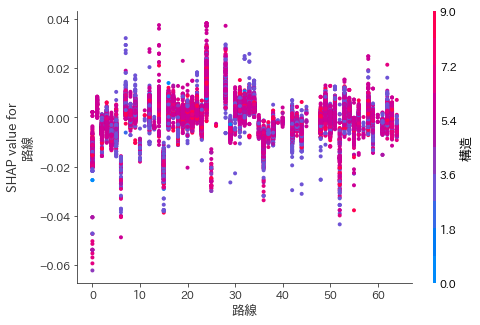

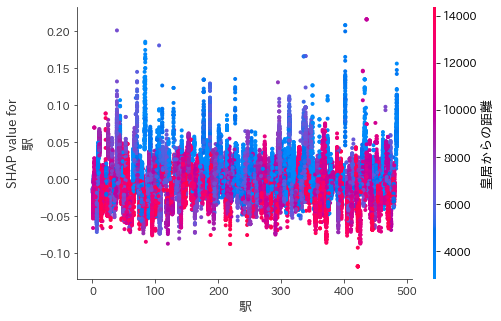

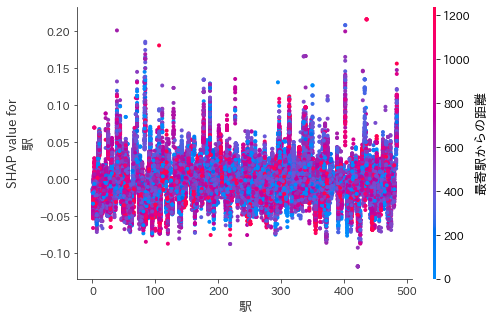

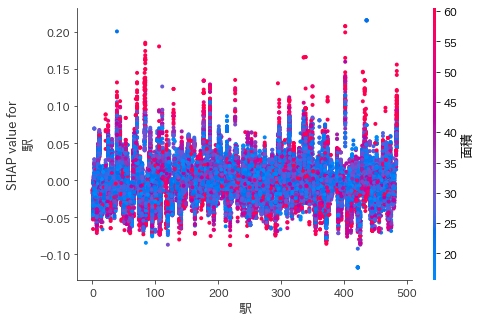

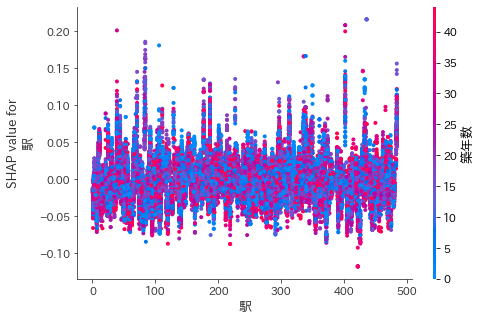

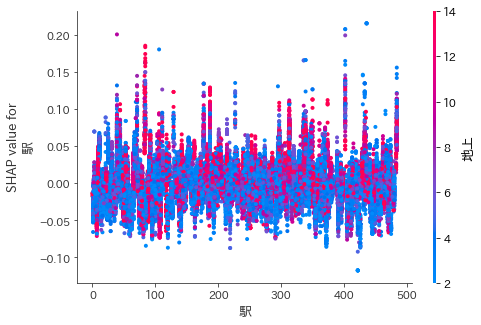

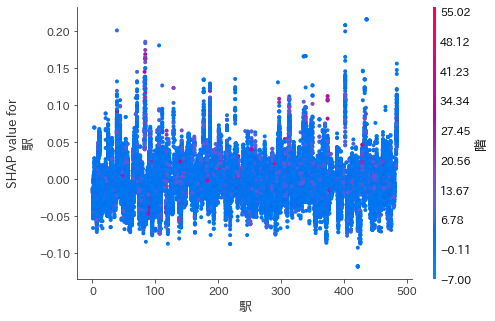

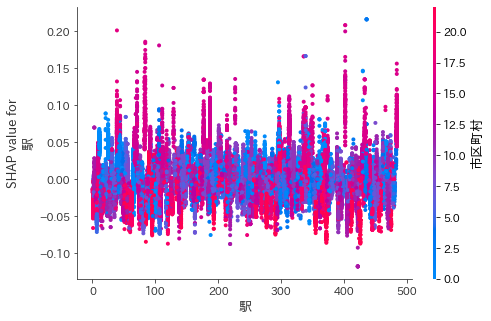

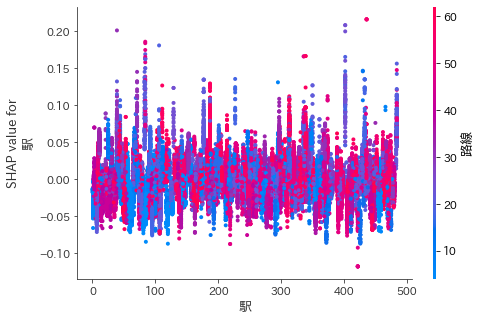

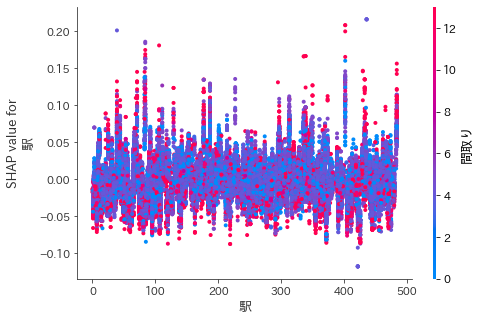

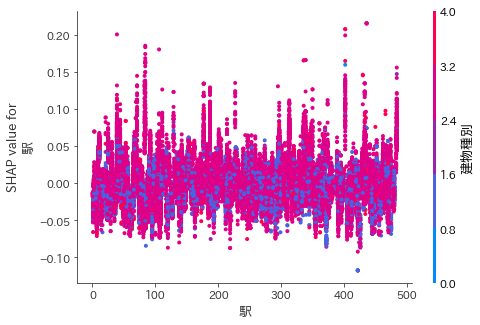

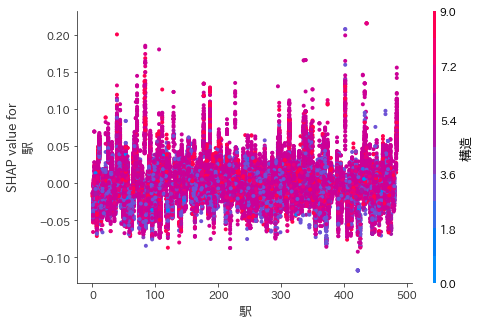

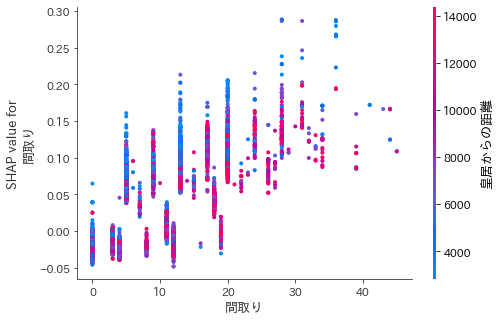

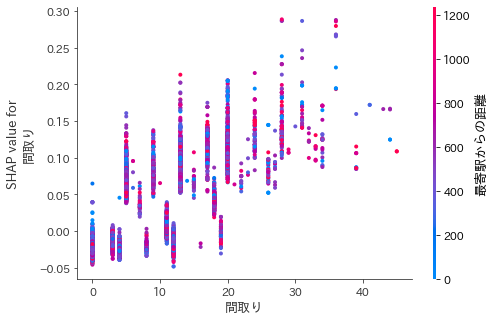

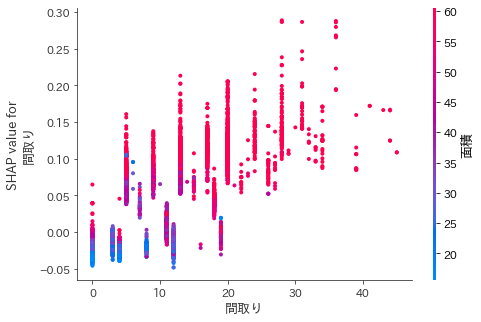

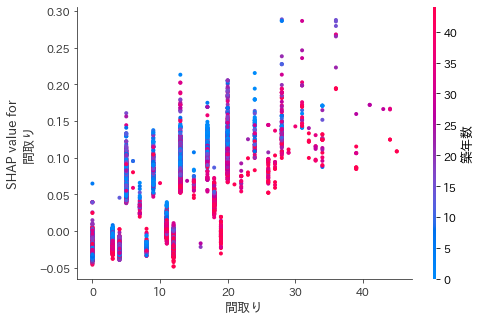

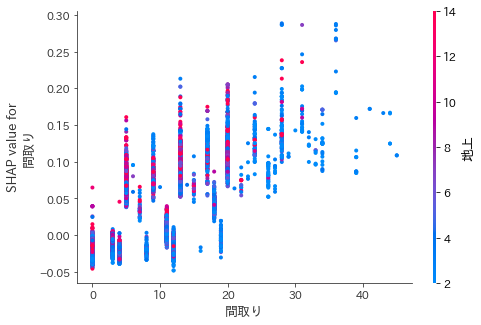

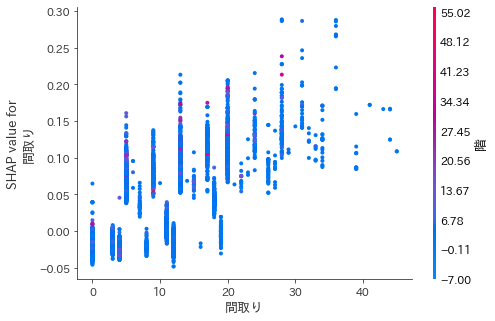

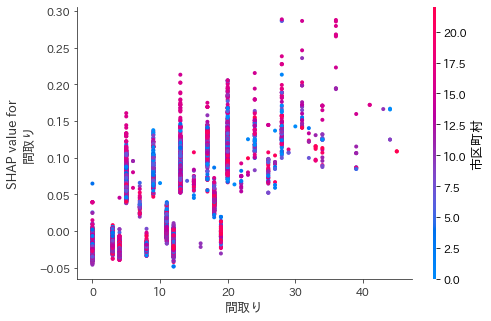

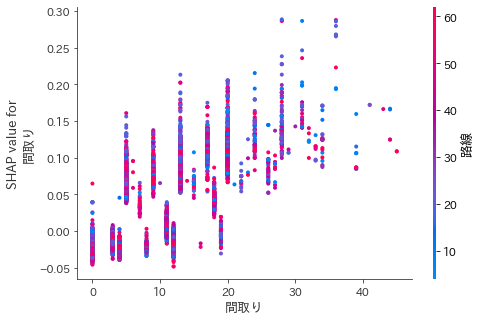

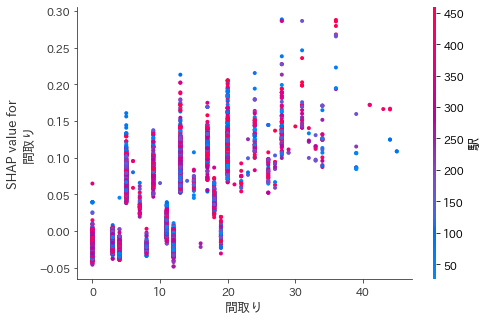

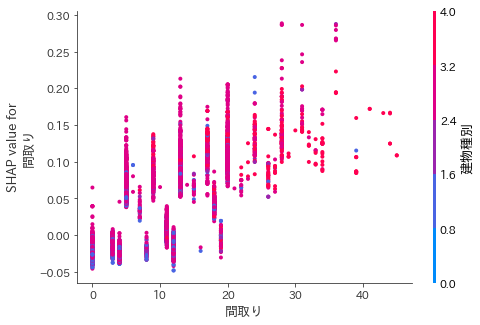

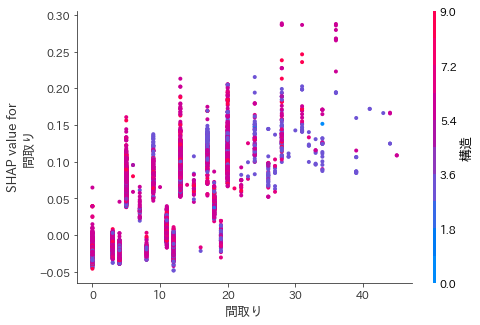

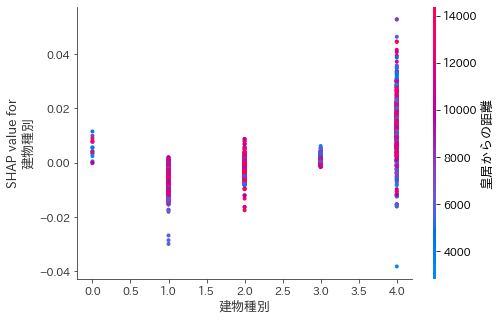

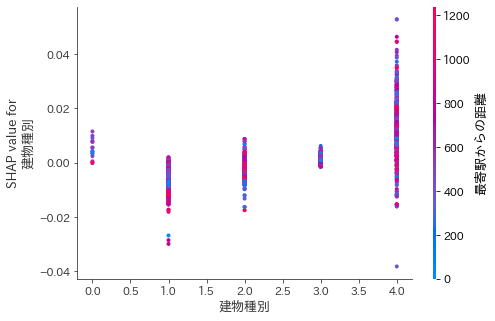

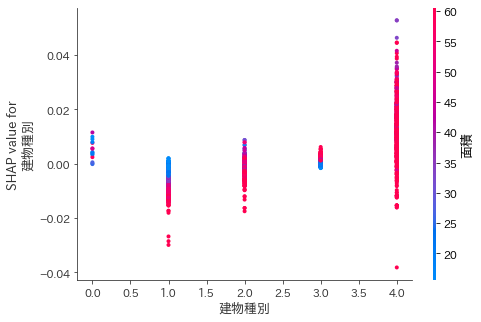

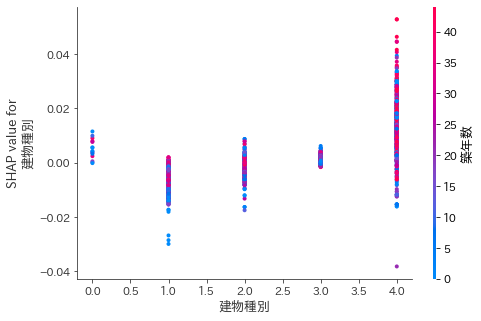

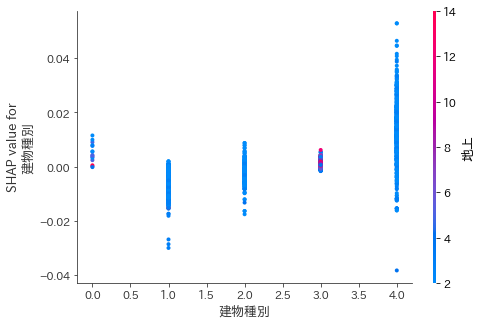

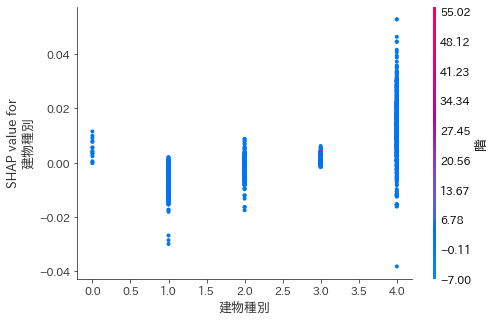

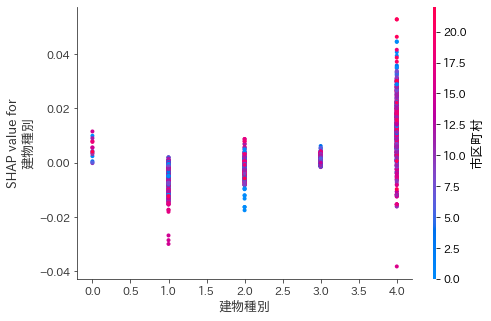

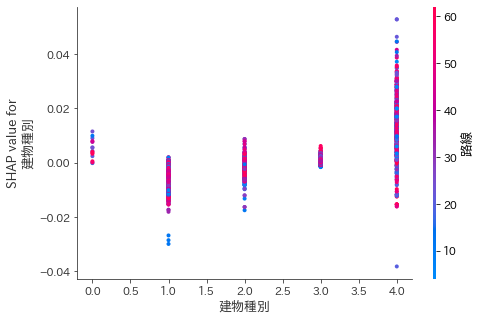

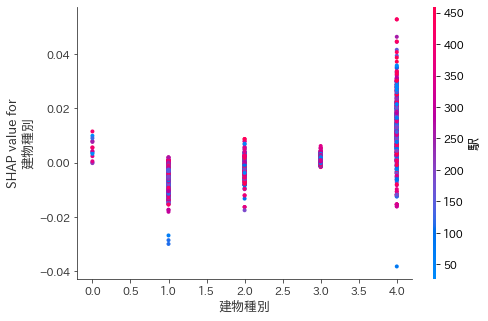

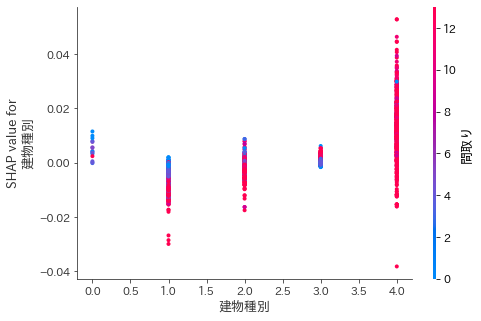

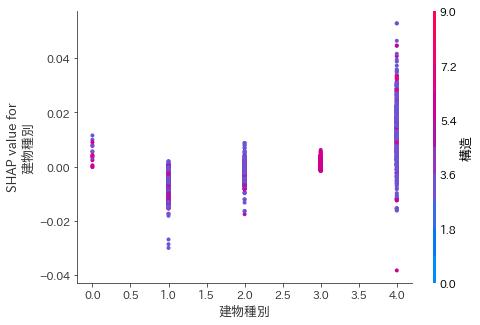

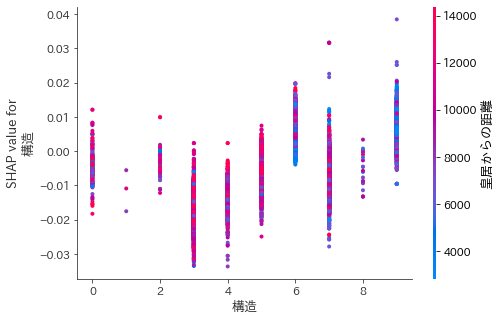

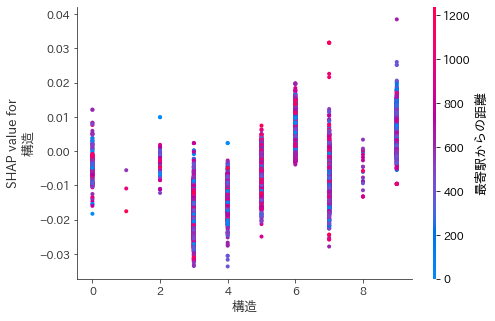

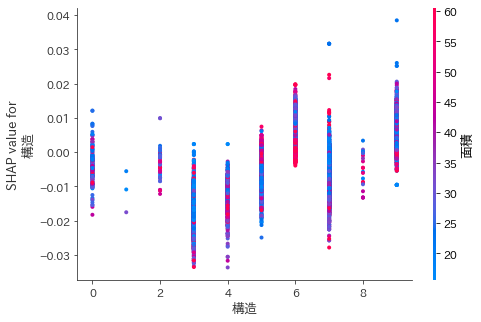

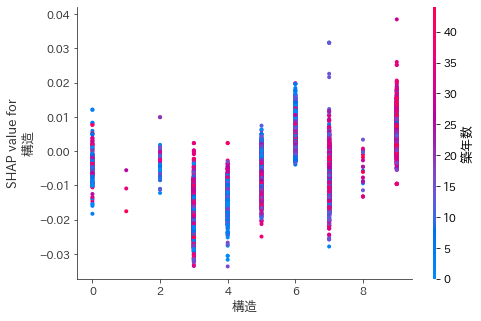

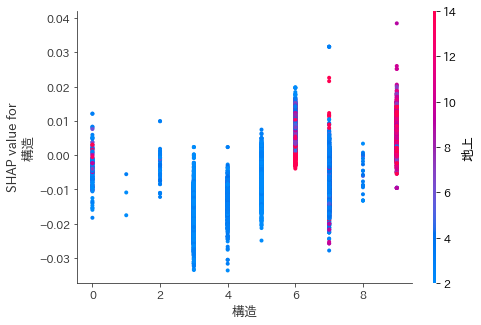

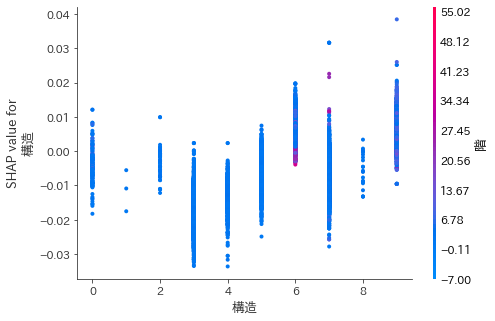

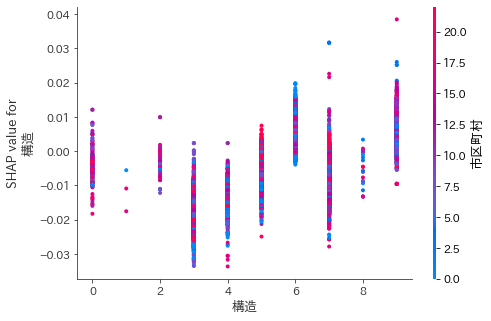

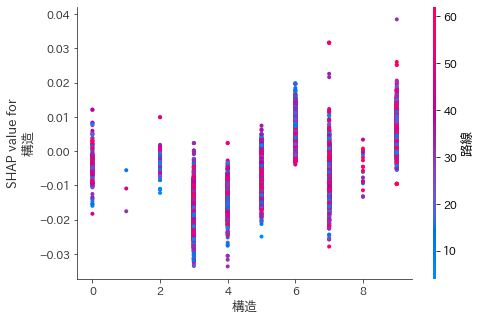

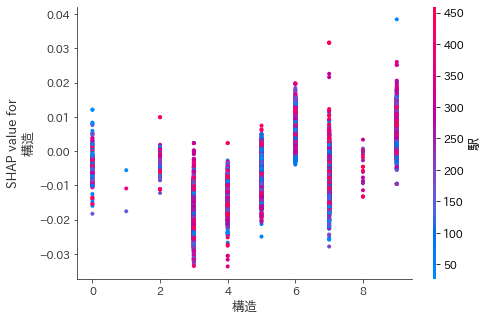

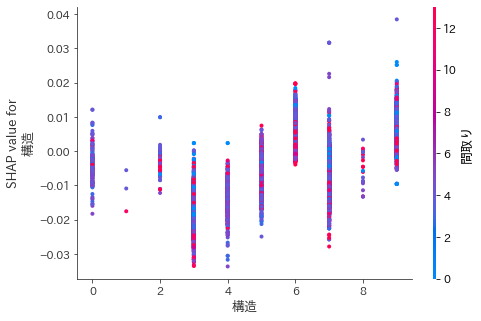

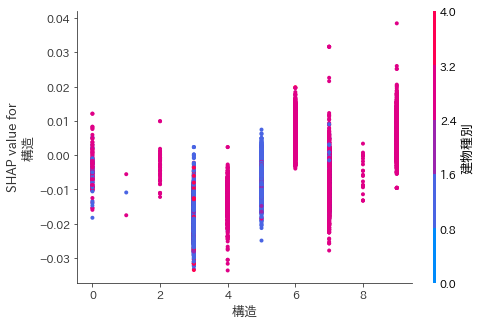

In [19]:
for feature_A in X_test.columns:
    for feature_B in X_test.columns:
        
        if feature_A == feature_B:
            continue

        shap.dependence_plot(
            ind=feature_A,
            interaction_index=feature_B,
            shap_values=shap_values,
            features=X_test,
            feature_names=X_test.columns,
            show=False
        )
#         plt.savefig(f'./data/image/shap/two_feature/shapvalue_{feature_A}_{feature_B}.png')
        plt.show()

In [20]:
X_test.columns

Index(['皇居からの距離', '最寄駅からの距離', '面積', '築年数', '地上', '階', '市区町村', '路線', '駅', '間取り',
       '建物種別', '構造'],
      dtype='object')

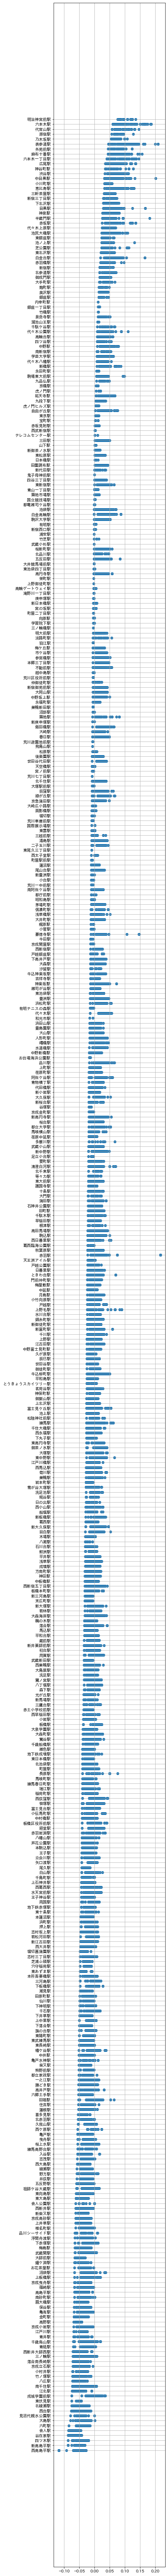

In [45]:
# カテゴリ変数を見やすくしたい
feature = '駅'

# 番号を本来のラベルに戻す
exec(f"X_test_nameback = X_test[feature].map(lambda x: table_{feature}.loc[table_{feature}['num']==x,'name'].values[0])")
# shap_valueの欲しい列
num = list(X_test.columns).index(feature)
shap_values_feature = shap_values[:,num]
table = pd.DataFrame(
    np.c_[X_test_nameback,shap_values_feature],
    columns=[feature,'shap_values']
)

# グラフを描く
height = len(X_test[feature].unique())/4
plt.figure(figsize=(5,height))
plt.grid()
plt.scatter(
    table.sort_values('shap_values')['shap_values'].tolist(),
    table.sort_values('shap_values')[feature].tolist(),
)
# plt.savefig(f'./data/image/shap/one_feature/shapvalue_{feature}.png')
plt.show()

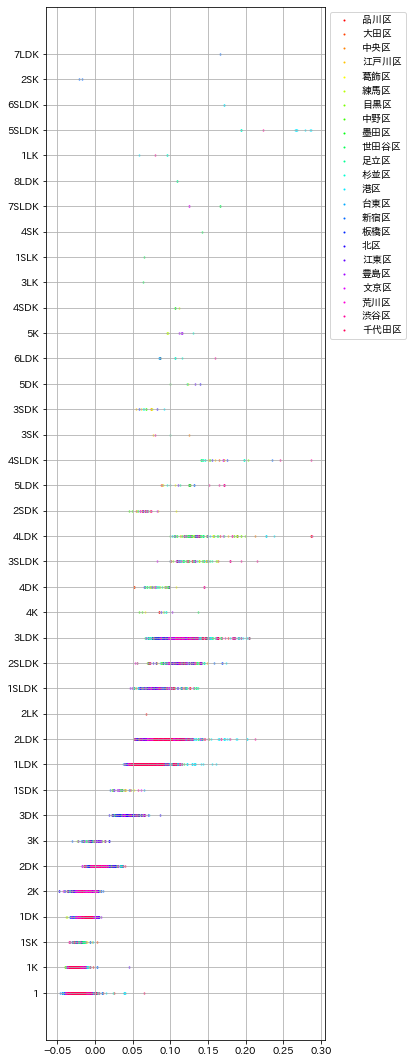

In [22]:
# カテゴリ変数による色の違いを見やすくしたい
# 10秒待つ（駅変数はかなり待つ）

feature = '間取り'
category_feature = '市区町村'

# 番号を本来のラベルに戻す
exec(f"X_test_nameback_A = X_test[feature].map(lambda x: table_{feature}.loc[table_{feature}['num']==x,'name'].values[0])")
exec(f"X_test_nameback_B = X_test[category_feature].map(lambda x: table_{category_feature}.loc[table_{category_feature}['num']==x,'name'].values[0])")
# shap_valueの欲しい列
num = list(X_test.columns).index(feature)
shap_values_feature = shap_values[:,num]
table = pd.DataFrame(
    np.c_[X_test_nameback_A,X_test_nameback_B,shap_values_feature],
    columns=[feature,category_feature,'shap_values']
)

# グラフを描く
height = len(X_test[feature].unique())/2
plt.figure(figsize=(5,height))
all_ = len(table[category_feature].unique())
order = table[category_feature].unique()
for num,value in enumerate(table[category_feature].unique()):
    condition = table[category_feature] == value
    plt.grid()
    plt.scatter(
        table.sort_values('shap_values').loc[condition,'shap_values'].tolist(),
        table.sort_values('shap_values').loc[condition,feature].tolist(),
        color=cm.hsv(num/all_),
        s=1
    )
plt.legend(order,bbox_to_anchor=(1,1))
plt.show()


<Figure size 360x414 with 0 Axes>

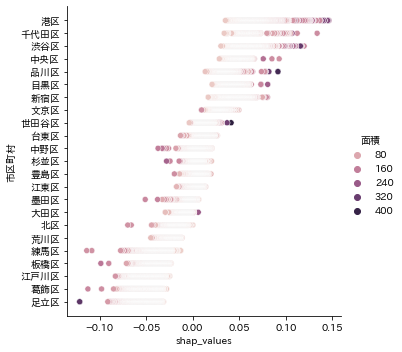

In [42]:
# カテゴリ変数による色の違いを見やすくしたい
# 10秒待つ（駅変数はかなり待つ）

feature = '市区町村'
quantity_feature = '面積'

# 番号を本来のラベルに戻す
exec(f"X_test_nameback_A = X_test[feature].map(lambda x: table_{feature}.loc[table_{feature}['num']==x,'name'].values[0])")
X_test_nameback_B = X_test[quantity_feature]
# shap_valueの欲しい列
num = list(X_test.columns).index(feature)
shap_values_feature = shap_values[:,num]
table = pd.DataFrame(
    np.c_[X_test_nameback_A,X_test_nameback_B,shap_values_feature],
    columns=[feature,quantity_feature,'shap_values']
)

# グラフを描く
height = len(X_test[feature].unique())/4
plt.figure(figsize=(5,height))
# all_ = len(table[category_feature].unique())
# order = table[category_feature].unique()
# for num,value in enumerate(table[category_feature].unique()):
#     condition = table[category_feature] == value
sns.relplot(data=table.sort_values('shap_values', ascending=False),
            x='shap_values',
            y=feature,
            hue=quantity_feature,
)
# plt.legend(order,bbox_to_anchor=(1,1))
plt.savefig("./data/image/shap_ward_area_sns.png")
plt.show()


In [39]:
table

市区町村     面積 shap_values
0       品川区  21.75    0.028498
1       大田区  81.84   -0.004315
2       中央区  21.37    0.041776
3      江戸川区  44.06   -0.060051
4       葛飾区  22.77     -0.0484
...     ...    ...         ...
58823  江戸川区   32.0   -0.058619
58824   台東区   26.3    0.006214
58825   品川区  31.57    0.033283
58826   大田区  21.09   -0.012639
58827   足立区  20.41   -0.041539

[58828 rows x 3 columns]

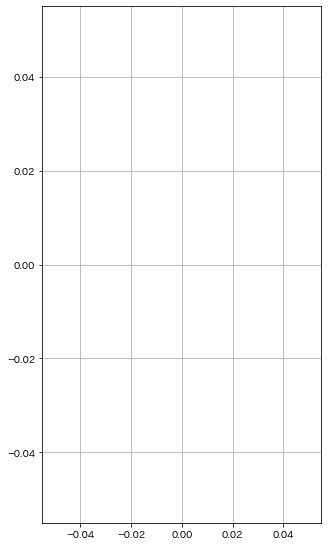

In [23]:
# グラフを描く
height = len(X_test[feature].unique())/4
plt.figure(figsize=(5,height))
all_ = len(table[category_feature].unique())
order = table[category_feature].unique()

condition = table[category_feature] == '木造'
plt.grid()
plt.scatter(
    table.sort_values('shap_values').loc[condition,'shap_values'].tolist(),
    table.sort_values('shap_values').loc[condition,feature].tolist(),
    color=cm.hsv(num/all_),
    s=1
)

plt.show()


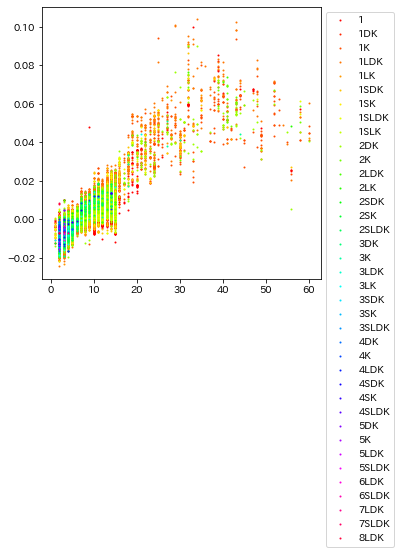

In [24]:
# カテゴリ変数による色の違いを見やすくしたい
# legendの色付けが間違っているっぽい？

feature = '地上'
category_feature = '間取り'

# 番号を本来のラベルに戻す
X_test_nameback_A = X_test[feature]
exec(f"X_test_nameback_B = X_test[category_feature].map(lambda x: table_{category_feature}.loc[table_{category_feature}['num']==x,'name'].values[0])")
# shap_valueの欲しい列
num = list(X_test.columns).index(feature)
shap_values_feature = shap_values[:,num]
# 必要な変数のテーブル
table = pd.DataFrame(
    np.c_[X_test_nameback_A,X_test_nameback_B,shap_values_feature],
    columns=[feature,category_feature,'shap_values']
)

# グラフを描く
# height = len(X_test[feature].unique())/4
plt.figure(figsize=(5,5))
all_ = len(table[category_feature].unique())
order = sorted(table[category_feature].unique())
for num,value in enumerate(table[category_feature].unique()):
    condition = table[category_feature] == value
    plt.grid()
    plt.scatter(
        table.sort_values('shap_values').loc[condition,feature].tolist(),
        table.sort_values('shap_values').loc[condition,'shap_values'].tolist(),
        color=cm.hsv(num/all_),
        s=1
    )
plt.legend(order,bbox_to_anchor=(1,1))
plt.show()


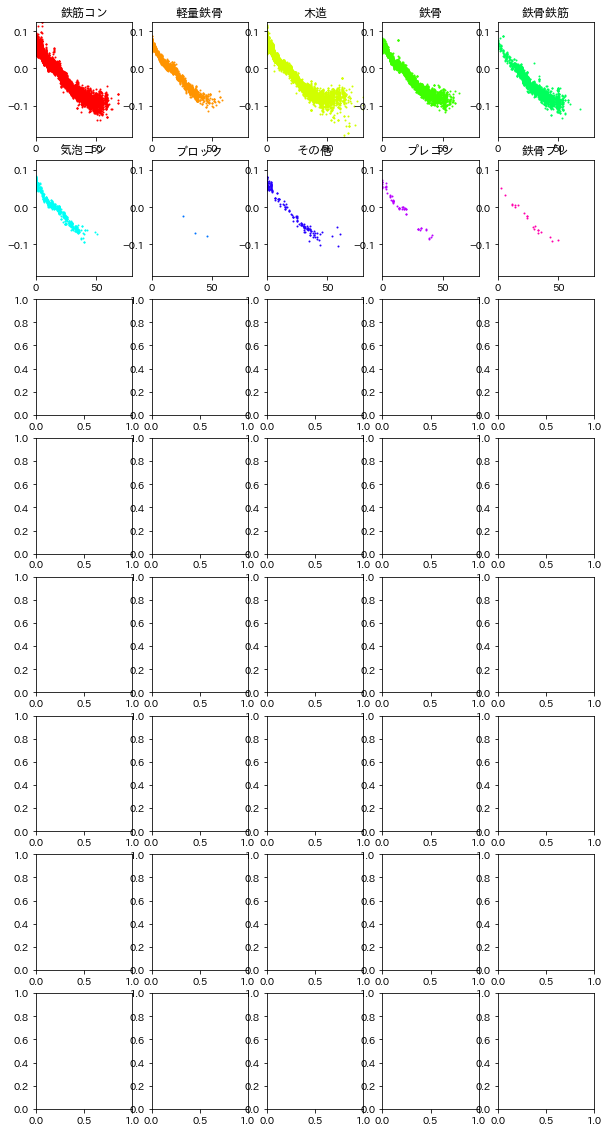

In [26]:
# カテゴリ変数による色の違いを見やすくしたい

feature = '築年数'
category_feature = '構造'

# 番号を本来のラベルに戻す
X_test_nameback_A = X_test[feature]
exec(f"X_test_nameback_B = X_test[category_feature].map(lambda x: table_{category_feature}.loc[table_{category_feature}['num']==x,'name'].values[0])")
# shap_valueの欲しい列
num = list(X_test.columns).index(feature)
shap_values_feature = shap_values[:,num]
# 必要な変数のテーブル
table = pd.DataFrame(
    np.c_[X_test_nameback_A,X_test_nameback_B,shap_values_feature],
    columns=[feature,category_feature,'shap_values']
)

# グラフを描く
# height = len(X_test[feature].unique())/4
nrows = 8
ncols = 5
xmin = table[feature].min()
xmax = table[feature].max()
ymin = table['shap_values'].min()
ymax = table['shap_values'].max()
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10,20))
all_ = len(table[category_feature].unique())
# order = sorted(table[category_feature].unique())
for num,value in enumerate(table[category_feature].unique()):
    row=int(num/ncols)
    col=num%ncols
    condition = table[category_feature] == value
    axes[row,col].scatter(
        table.sort_values('shap_values').loc[condition,feature].tolist(),
        table.sort_values('shap_values').loc[condition,'shap_values'].tolist(),
        color=cm.hsv(num/all_),
        s=1
    )
    axes[row, col].set_title(value)
    axes[row, col].set_xlim(xmin, xmax)
    axes[row, col].set_ylim(ymin, ymax)
# plt.legend(bbox_to_anchor=(1,1))
plt.show()


In [27]:
# shapテーブルを作る
X_test_shap = copy.copy(X_test)
shap_features = []
noshap_features = []

for num, feature in enumerate(X_test.columns):
    X_test_shap[f'shap_{feature}'] = shap_values[:,num]
    shap_features.append(f'shap_{feature}')
    noshap_features.append(feature)
    
X_test_shap['予測'] = y_test_pred
X_test_shap['真値'] = y_test
X_test_shap['残差'] = y_test_pred - y_test

In [28]:
X_test_shap

皇居からの距離     最寄駅からの距離     面積  築年数  地上     階 市区町村  路線    駅 間取り  \
25407    9877.674134   605.083207  21.75    4   5   2.0    6   2  354   4   
154497  10493.538889   710.239276  81.84   33   2   2.0    8  54  145  26   
83983    2166.689856   156.231818  21.37   19  12   9.0    1  21   79   4   
167642  14232.826744   946.030601  44.06    0   2   1.0   13  50  362  13   
168458  13671.848361   786.349539  22.77    0   2   1.0   20   6  269   4   
...              ...          ...    ...  ...  ..   ...  ...  ..  ...  ..   
189128   9725.771070   337.499287  32.00   28   4   1.0   13  62  206  12   
62524    5314.944234  1189.826031  26.30    0   8   8.0    5   0  305   4   
109977   9238.397047     0.000000  31.57   13   3   2.0    6  34  409   4   
50902   14064.626527   865.172596  21.09   15  20  14.0    8  54  395   4   
90429    7431.009054     0.000000  20.41    0   4   1.0   22   5   98   4   

        ...    shap_階 shap_市区町村   shap_路線    shap_駅  shap_間取り  shap_建物種別  \
25407   ... -0.001678  0.028498 -0.006181 -0.014973 -0.027552   0.000291   
154497  ... -0.007939 -0.004315 -0.003156  0.015419  0.094318   0.006802   
83983   ...  0.014704  0.041776  0.002964  0.001777 -0.032455   0.000110   
167642  ... -0.013518 -0.060051 -0.004497 -0.030015  0.080307  -0.004278   
168458  ... -0.012239 -0.048400 -0.016626 -0.019532 -0.025986  -0.002792   
...     ...       ...       ...       ...       ...       ...        ...   
189128  ... -0.016352 -0.058619  0.001587  0.005718 -0.011887   0.000263   
62524   ...  0.019348  0.006214 -0.012353  0.002220 -0.026871   0.000333   
109977  ... -0.010547  0.033283  0.003512 -0.016140 -0.026077   0.000079   
50902   ...  0.026346 -0.012639  0.000570  0.014574 -0.027965   0.000160   
90429   ... -0.014608 -0.041539 -0.004139 -0.006654 -0.023759  -0.000144   

         shap_構造        予測        真値        残差  
25407   0.008472  0.940270  0.929419  0.010851  
154497 -0.008941  1.284149  1.301030 -0.016881  
83983   0.007916  0.952431  0.913814  0.038617  
167642 -0.017402  1.047967  1.041393  0.006575  
168458 -0.022223  0.831202  0.806180  0.025022  
...          ...       ...       ...       ...  
189128 -0.005302  0.877342  0.799341  0.078001  
62524   0.007585  1.022163  1.041393 -0.019230  
109977 -0.017067  0.963703  1.049218 -0.085515  
50902   0.008843  0.924609  0.919078  0.005531  
90429   0.006636  0.868487  0.869232 -0.000745  

[58828 rows x 27 columns]

In [79]:
print(suumo.loc[191971,'url'])

https://suumo.jp/chintai/jnc_000074894730/?bc=100205729340


In [78]:
X_test_shap.sort_values('真値', ascending=True)[['残差','予測','真値']]

残差        予測        真値
191971  0.434420  0.434420  0.000000
58089  -0.010345  0.332078  0.342423
162709  0.120423  0.482151  0.361728
151595  0.343168  0.704896  0.361728
58090   0.021301  0.383029  0.361728
...          ...       ...       ...
108705 -0.010396  2.387544  2.397940
165766 -0.034527  2.363413  2.397940
60567  -0.206689  2.255709  2.462398
68     -0.051763  2.492305  2.544068
60568  -0.051763  2.492305  2.544068

[58828 rows x 3 columns]

In [80]:
i = 191971
print(X_test_shap.loc[i,noshap_features])
print('真値log10(家賃)：',X_test_shap.loc[i,'真値'])
print('予測log10(家賃)：',X_test_shap.loc[i,'予測'])
print('真値家賃：',10**X_test_shap.loc[i,'真値'])
print('予測家賃：',10**X_test_shap.loc[i,'予測'])

皇居からの距離     9307.274160
最寄駅からの距離     548.668089
面積             7.000000
築年数            6.000000
地上             2.000000
階              1.000000
市区町村           2.000000
路線            42.000000
駅            299.000000
間取り            0.000000
建物種別           1.000000
構造             3.000000
Name: 191971, dtype: float64
真値log10(家賃)： 0.0
予測log10(家賃)： 0.4344195678599798
真値家賃： 1.0
予測家賃： 2.7190648636306634


In [81]:
# 個別に影響力を見れる
shap.force_plot(
    explainer.expected_value,
    np.array(X_test_shap.loc[i,shap_features]),
    X_test_shap.loc[i,noshap_features],
    feature_names=X_test.columns
)

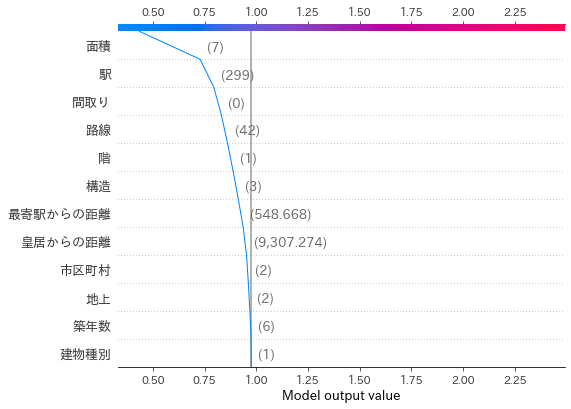

In [82]:
xmin = X_test_shap['予測'].min()
xmax = X_test_shap['予測'].max()

shap.decision_plot(
    explainer.expected_value,
    np.array(X_test_shap.loc[i,shap_features]),
    X_test_shap.loc[i,noshap_features],
    xlim=[xmin,xmax],
    show=False
)
plt.savefig("./data/image/cheapproperty01.png")
plt.show()

In [38]:
shap.decision_plot?

# PartialDependence, IndividualConditionalExpectation

In [292]:
from sklearn.inspection import PartialDependenceDisplay

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


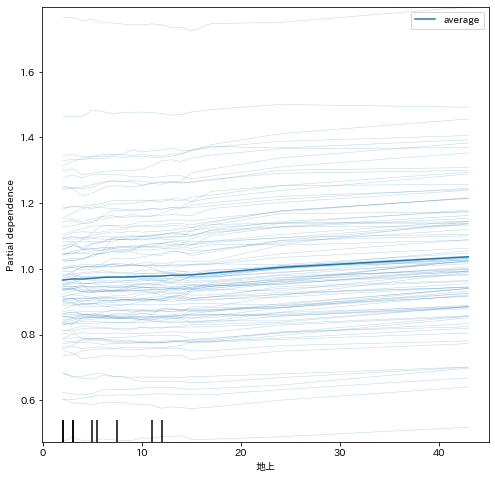

In [303]:
# 結構計算重いぞ
fig, ax = plt.subplots(figsize=(8,8))
PartialDependenceDisplay.from_estimator(
    estimator=LGBM,
    X=X_test[:100],
    features = ["地上"],
    kind='both',
    ax=ax
)
fig.show()

In [171]:
X_train_before.shape

(137265, 12)